In [1]:
!pip install pandas numpy tensorflow keras scikit-learn seaborn matplotlib h5py torch tqdm torchsummary


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!pip install pytorch_tcn


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
import datetime as dt
import random
import os
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, GRU,LSTM, Dense,Lambda,Conv1D
from pandas.tseries.offsets import DateOffset
from keras.layers import AdditiveAttention
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from fastprogress import master_bar, progress_bar
from tqdm import tqdm
import glob
from torchsummary import summary
from sklearn.metrics import mean_absolute_percentage_error
from pytorch_tcn import TCN

TRAIN_STEPS = 168
OUTPUT_STEPS = 1
OFFSET = 1
LSTM_DIM = 64
MAX_EPOCH = 200
BATCH_SIZE = 32
LEA_RAT = 0.01


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is:",device)

device is: cpu


In [4]:
from google.colab import files
uploaded = files.upload()


Saving data_set_adjusted.csv to data_set_adjusted.csv


In [5]:
FILE_DIR = '/content/data_set_adjusted.csv'
data = pd.DataFrame()
metro_data = pd.DataFrame()


In [6]:
import pandas as pd

# Replace the filename below with the exact name shown in the upload
data = pd.read_csv('data_set_adjusted.csv')

# See the first few rows to confirm it loaded
data.head()




,datetime,KW,CHWTON,CHWTON(KW),HTmmBTU,HTmmBTU(KW),Combined mmBTU,Combined mmBTU(KW),KW_PF,CHWTON_PF,...,DHI,DNI,GHI,Dew Point,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure
0,2018-01-01 00:00:00,17007.47,2021.27,7117.147887,13.17,3873.529412,95.46,28076.47059,0.605755,0.253492,...,0.0,0.0,0.0,-10.5,1.50,0.8,69.0,19.230,12.3,972.0
1,2018-01-01 01:00:00,16742.88,1841.30,6483.450704,15.24,4482.352941,94.46,27782.35294,0.602644,0.233366,...,0.0,0.0,0.0,-10.9,1.50,0.8,69.0,19.140,11.9,972.0
2,2018-01-01 02:00:00,16874.22,1772.96,6242.816901,16.36,4811.764706,95.22,28005.88235,0.602524,0.222911,...,0.0,0.0,0.0,-11.2,1.50,0.8,68.0,19.895,11.0,972.0
3,2018-01-01 03:00:00,16892.98,1736.67,6115.035211,16.03,4714.705882,94.51,27797.05882,0.607725,0.219989,...,0.0,0.0,0.0,-11.4,1.55,0.9,70.0,20.850,10.0,972.0
4,2018-01-01 04:00:00,16939.45,1706.68,6009.436620,15.63,4597.058824,93.91,27620.58824,0.613291,0.217571,...,0.0,0.0,0.0,-11.7,1.60,0.9,72.5,21.435,9.3,972.0


In [7]:
# Show first few rows
data.head()


,datetime,KW,CHWTON,CHWTON(KW),HTmmBTU,HTmmBTU(KW),Combined mmBTU,Combined mmBTU(KW),KW_PF,CHWTON_PF,...,DHI,DNI,GHI,Dew Point,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure
0,2018-01-01 00:00:00,17007.47,2021.27,7117.147887,13.17,3873.529412,95.46,28076.47059,0.605755,0.253492,...,0.0,0.0,0.0,-10.5,1.50,0.8,69.0,19.230,12.3,972.0
1,2018-01-01 01:00:00,16742.88,1841.30,6483.450704,15.24,4482.352941,94.46,27782.35294,0.602644,0.233366,...,0.0,0.0,0.0,-10.9,1.50,0.8,69.0,19.140,11.9,972.0
2,2018-01-01 02:00:00,16874.22,1772.96,6242.816901,16.36,4811.764706,95.22,28005.88235,0.602524,0.222911,...,0.0,0.0,0.0,-11.2,1.50,0.8,68.0,19.895,11.0,972.0
3,2018-01-01 03:00:00,16892.98,1736.67,6115.035211,16.03,4714.705882,94.51,27797.05882,0.607725,0.219989,...,0.0,0.0,0.0,-11.4,1.55,0.9,70.0,20.850,10.0,972.0
4,2018-01-01 04:00:00,16939.45,1706.68,6009.436620,15.63,4597.058824,93.91,27620.58824,0.613291,0.217571,...,0.0,0.0,0.0,-11.7,1.60,0.9,72.5,21.435,9.3,972.0


In [8]:
# Show the column names
print("Columns:", data.columns.tolist())

# Show data types and missing values
data.info()

# Describe numeric columns
data.describe()


Columns: ['datetime', 'KW', 'CHWTON', 'CHWTON(KW)', 'HTmmBTU', 'HTmmBTU(KW)', 'Combined mmBTU', 'Combined mmBTU(KW)', 'KW_PF', 'CHWTON_PF', 'HTmmBTU_PF', 'DHI', 'DNI', 'GHI', 'Dew Point', 'Wind Speed', 'Precipitable Water', 'Wind Direction', 'Relative Humidity', 'Temperature', 'Pressure']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   datetime            17520 non-null  object 
 1   KW                  17520 non-null  float64
 2   CHWTON              17520 non-null  float64
 3   CHWTON(KW)          17520 non-null  float64
 4   HTmmBTU             17520 non-null  float64
 5   HTmmBTU(KW)         17520 non-null  float64
 6   Combined mmBTU      17520 non-null  float64
 7   Combined mmBTU(KW)  17520 non-null  float64
 8   KW_PF               17520 non-null  float64
 9   CHWTON_PF           17520 non-null  float64
 10  HTmmBTU_

,KW,CHWTON,CHWTON(KW),HTmmBTU,HTmmBTU(KW),Combined mmBTU,Combined mmBTU(KW),KW_PF,CHWTON_PF,HTmmBTU_PF,DHI,DNI,GHI,Dew Point,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure
count,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000
mean,23119.086826,8006.308056,28191.227263,7.420783,2182.582972,182.393543,53645.159440,0.460945,0.484634,0.051589,55.580708,301.323716,238.212500,3.339107,1.946341,1.739572,181.694207,33.770775,23.085853,966.671490
std,4695.089111,4619.201110,16264.790932,2.632811,774.356061,67.878988,19964.408283,0.090274,0.122587,0.035417,75.191871,369.232625,320.062728,8.096060,1.172097,1.157123,84.562451,20.456770,10.208706,4.061074
min,12291.700000,1472.840000,5186.056338,3.810000,1120.588235,72.340000,21276.470590,0.278525,0.192751,0.011841,0.000000,0.000000,0.000000,-23.900000,0.050000,0.100000,2.000000,2.970000,-3.000000,955.000000
25%,19645.832500,4015.847500,14140.308102,5.250000,1544.117647,124.620000,36652.941180,0.382888,0.385137,0.022293,0.000000,0.000000,0.000000,-2.400000,1.100000,0.900000,102.000000,17.390000,14.900000,964.000000
50%,22483.165000,7038.680000,24784.084505,6.600000,1941.176471,167.560000,49282.352940,0.451880,0.504538,0.039519,10.500000,18.000000,13.000000,2.700000,1.600000,1.350000,205.000000,29.540000,22.875000,966.000000
75%,25877.235000,11514.562500,40544.234153,9.070000,2667.647059,232.012500,68238.970585,0.538515,0.590976,0.073056,97.500000,692.500000,472.500000,8.600000,2.600000,2.250000,252.000000,45.880000,30.700000,969.000000
max,39383.450000,21393.600000,75329.577460,19.190000,5644.117647,378.990000,111467.647100,0.671097,0.704017,0.189868,479.000000,1052.500000,1070.000000,24.900000,9.250000,7.600000,358.000000,100.000000,47.100000,985.000000


In [9]:
data.columns


Index(['datetime', 'KW', 'CHWTON', 'CHWTON(KW)', 'HTmmBTU', 'HTmmBTU(KW)',
       'Combined mmBTU', 'Combined mmBTU(KW)', 'KW_PF', 'CHWTON_PF',
       'HTmmBTU_PF', 'DHI', 'DNI', 'GHI', 'Dew Point', 'Wind Speed',
       'Precipitable Water', 'Wind Direction', 'Relative Humidity',
       'Temperature', 'Pressure'],
      dtype='object')

In [10]:
data.head()
data.columns
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   datetime            17520 non-null  object 
 1   KW                  17520 non-null  float64
 2   CHWTON              17520 non-null  float64
 3   CHWTON(KW)          17520 non-null  float64
 4   HTmmBTU             17520 non-null  float64
 5   HTmmBTU(KW)         17520 non-null  float64
 6   Combined mmBTU      17520 non-null  float64
 7   Combined mmBTU(KW)  17520 non-null  float64
 8   KW_PF               17520 non-null  float64
 9   CHWTON_PF           17520 non-null  float64
 10  HTmmBTU_PF          17520 non-null  float64
 11  DHI                 17520 non-null  float64
 12  DNI                 17520 non-null  float64
 13  GHI                 17520 non-null  float64
 14  Dew Point           17520 non-null  float64
 15  Wind Speed          17520 non-null  float64
 16  Prec

In [11]:
print(data.columns.tolist())


['datetime', 'KW', 'CHWTON', 'CHWTON(KW)', 'HTmmBTU', 'HTmmBTU(KW)', 'Combined mmBTU', 'Combined mmBTU(KW)', 'KW_PF', 'CHWTON_PF', 'HTmmBTU_PF', 'DHI', 'DNI', 'GHI', 'Dew Point', 'Wind Speed', 'Precipitable Water', 'Wind Direction', 'Relative Humidity', 'Temperature', 'Pressure']


In [12]:
import pandas as pd

raw_df = pd.read_csv('data_set_adjusted.csv')
print(raw_df.columns.tolist())


['datetime', 'KW', 'CHWTON', 'CHWTON(KW)', 'HTmmBTU', 'HTmmBTU(KW)', 'Combined mmBTU', 'Combined mmBTU(KW)', 'KW_PF', 'CHWTON_PF', 'HTmmBTU_PF', 'DHI', 'DNI', 'GHI', 'Dew Point', 'Wind Speed', 'Precipitable Water', 'Wind Direction', 'Relative Humidity', 'Temperature', 'Pressure']


In [13]:
import pandas as pd

# Load the dataset again
data = pd.read_csv('data_set_adjusted.csv')

# Clean column names to remove spaces
data.columns = data.columns.str.strip()

# Convert 'datetime' to datetime type
data['datetime'] = pd.to_datetime(data['datetime'])

# Set as index
data.set_index('datetime', inplace=True)

# Sort index (optional but good practice)
data = data.sort_index()


In [14]:
print(data.index)
data.head()


DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-12-31 14:00:00', '2019-12-31 15:00:00',
               '2019-12-31 16:00:00', '2019-12-31 17:00:00',
               '2019-12-31 18:00:00', '2019-12-31 19:00:00',
               '2019-12-31 20:00:00', '2019-12-31 21:00:00',
               '2019-12-31 22:00:00', '2019-12-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=17520, freq=None)


,KW,CHWTON,CHWTON(KW),HTmmBTU,HTmmBTU(KW),Combined mmBTU,Combined mmBTU(KW),KW_PF,CHWTON_PF,HTmmBTU_PF,DHI,DNI,GHI,Dew Point,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure
datetime,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,17007.47,2021.27,7117.147887,13.17,3873.529412,95.46,28076.47059,0.605755,0.253492,0.137964,0.0,0.0,0.0,-10.5,1.50,0.8,69.0,19.230,12.3,972.0
2018-01-01 01:00:00,16742.88,1841.30,6483.450704,15.24,4482.352941,94.46,27782.35294,0.602644,0.233366,0.161338,0.0,0.0,0.0,-10.9,1.50,0.8,69.0,19.140,11.9,972.0
2018-01-01 02:00:00,16874.22,1772.96,6242.816901,16.36,4811.764706,95.22,28005.88235,0.602524,0.222911,0.171813,0.0,0.0,0.0,-11.2,1.50,0.8,68.0,19.895,11.0,972.0
2018-01-01 03:00:00,16892.98,1736.67,6115.035211,16.03,4714.705882,94.51,27797.05882,0.607725,0.219989,0.169612,0.0,0.0,0.0,-11.4,1.55,0.9,70.0,20.850,10.0,972.0
2018-01-01 04:00:00,16939.45,1706.68,6009.436620,15.63,4597.058824,93.91,27620.58824,0.613291,0.217571,0.166436,0.0,0.0,0.0,-11.7,1.60,0.9,72.5,21.435,9.3,972.0


In [15]:
data.head()
data.columns


Index(['KW', 'CHWTON', 'CHWTON(KW)', 'HTmmBTU', 'HTmmBTU(KW)',
       'Combined mmBTU', 'Combined mmBTU(KW)', 'KW_PF', 'CHWTON_PF',
       'HTmmBTU_PF', 'DHI', 'DNI', 'GHI', 'Dew Point', 'Wind Speed',
       'Precipitable Water', 'Wind Direction', 'Relative Humidity',
       'Temperature', 'Pressure'],
      dtype='object')

In [16]:
import pandas as pd

FILE_DIR = '/content/data_set_adjusted.csv'
data = pd.read_csv(FILE_DIR)

# Show all column names
print("Columns:", data.columns.tolist())

# Show the first few rows
print("\nSample rows:")
print(data.head(3))


Columns: ['datetime', 'KW', 'CHWTON', 'CHWTON(KW)', 'HTmmBTU', 'HTmmBTU(KW)', 'Combined mmBTU', 'Combined mmBTU(KW)', 'KW_PF', 'CHWTON_PF', 'HTmmBTU_PF', 'DHI', 'DNI', 'GHI', 'Dew Point', 'Wind Speed', 'Precipitable Water', 'Wind Direction', 'Relative Humidity', 'Temperature', 'Pressure']

Sample rows:
              datetime        KW   CHWTON   CHWTON(KW)  HTmmBTU  HTmmBTU(KW)  \
0  2018-01-01 00:00:00  17007.47  2021.27  7117.147887    13.17  3873.529412   
1  2018-01-01 01:00:00  16742.88  1841.30  6483.450704    15.24  4482.352941   
2  2018-01-01 02:00:00  16874.22  1772.96  6242.816901    16.36  4811.764706   

   Combined mmBTU  Combined mmBTU(KW)     KW_PF  CHWTON_PF  ...  DHI  DNI  \
0           95.46         28076.47059  0.605755   0.253492  ...  0.0  0.0   
1           94.46         27782.35294  0.602644   0.233366  ...  0.0  0.0   
2           95.22         28005.88235  0.602524   0.222911  ...  0.0  0.0   

   GHI  Dew Point  Wind Speed  Precipitable Water  Wind Direction 

In [17]:
import pandas as pd

FILE_DIR = '/content/data_set_adjusted.csv'
data = pd.read_csv(FILE_DIR)

# Convert to datetime and set as index
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

# Confirm structure
print(data.index)
data.head()


DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-12-31 14:00:00', '2019-12-31 15:00:00',
               '2019-12-31 16:00:00', '2019-12-31 17:00:00',
               '2019-12-31 18:00:00', '2019-12-31 19:00:00',
               '2019-12-31 20:00:00', '2019-12-31 21:00:00',
               '2019-12-31 22:00:00', '2019-12-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=17520, freq=None)


,KW,CHWTON,CHWTON(KW),HTmmBTU,HTmmBTU(KW),Combined mmBTU,Combined mmBTU(KW),KW_PF,CHWTON_PF,HTmmBTU_PF,DHI,DNI,GHI,Dew Point,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure
datetime,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,17007.47,2021.27,7117.147887,13.17,3873.529412,95.46,28076.47059,0.605755,0.253492,0.137964,0.0,0.0,0.0,-10.5,1.50,0.8,69.0,19.230,12.3,972.0
2018-01-01 01:00:00,16742.88,1841.30,6483.450704,15.24,4482.352941,94.46,27782.35294,0.602644,0.233366,0.161338,0.0,0.0,0.0,-10.9,1.50,0.8,69.0,19.140,11.9,972.0
2018-01-01 02:00:00,16874.22,1772.96,6242.816901,16.36,4811.764706,95.22,28005.88235,0.602524,0.222911,0.171813,0.0,0.0,0.0,-11.2,1.50,0.8,68.0,19.895,11.0,972.0
2018-01-01 03:00:00,16892.98,1736.67,6115.035211,16.03,4714.705882,94.51,27797.05882,0.607725,0.219989,0.169612,0.0,0.0,0.0,-11.4,1.55,0.9,70.0,20.850,10.0,972.0
2018-01-01 04:00:00,16939.45,1706.68,6009.436620,15.63,4597.058824,93.91,27620.58824,0.613291,0.217571,0.166436,0.0,0.0,0.0,-11.7,1.60,0.9,72.5,21.435,9.3,972.0


In [18]:
# Data Preparation
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define target columns (multi-task)
target_cols = ['KW', 'CHWTON(KW)', 'HTmmBTU(KW)']

# Features: all except targets
feature_cols = [col for col in data.columns if col not in target_cols]

# Combine features and targets
all_cols = feature_cols + target_cols
data = data[all_cols]  # Ensure correct column order

# Normalize all data (including targets)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, index=data.index, columns=all_cols)



def create_sequences(df, input_steps=24, output_steps=1):
    X, y = [], []
    for i in range(len(df) - input_steps - output_steps):
        X_seq = df.iloc[i : i + input_steps].values
        y_seq = df.iloc[i + input_steps : i + input_steps + output_steps][target_cols].values
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)


X, y = create_sequences(scaled_df, input_steps=24, output_steps=1)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (17495, 24, 20)
y shape: (17495, 1, 3)


In [19]:
# Time-based split
#Train = First 70% of sequences
#Val = Next 15%
#Test = Last 15%

train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")


Train: (12246, 24, 20), (12246, 1, 3)
Val:   (2624, 24, 20), (2624, 1, 3)
Test:  (2625, 24, 20), (2625, 1, 3)


In [20]:
#Model Architecture Overview

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

def build_multi_task_model(input_shape, output_dim):
    inputs = Input(shape=input_shape)

    # Shared LSTM layers
    x = LSTM(128, return_sequences=False)(inputs)
    x = Dense(64, activation='relu')(x)

    # Separate output layers (multi-task)
    out_kw = Dense(1, name='KW')(x)
    out_chw = Dense(1, name='CHWTON')(x)
    out_ht = Dense(1, name='HTmmBTU')(x)

    # Combine outputs
    outputs = tf.keras.layers.Concatenate()([out_kw, out_chw, out_ht])

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Define the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (24, 20)
output_dim = y_train.shape[2]  # 3 targets

model = build_multi_task_model(input_shape, output_dim)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     76,288 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ KW (Dense)          │ (None, 1)         │         65 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CHWTON (Dense)      │ (None, 1)         │         65 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HTmmBTU (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3)         │          0 │ KW[0][0],         │
│ (Concatenate)       │                   │            │ CHWTON[0][0],     │
│                     │                   │            │ HTmmBTU[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,739 (331.01 KB)

 Trainable params: 84,739 (331.01 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Reshape y for training
y_train_reshaped = y_train[:, 0, :]
y_val_reshaped = y_val[:, 0, :]

# Train the model
history = model.fit(
    X_train, y_train_reshaped,
    validation_data=(X_val, y_val_reshaped),
    epochs=30,  # Adjust epochs based on your preference
    batch_size=32  # You can try a larger batch size if you have more resources
)


Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.0107 - mae: 0.0584 - val_loss: 0.0024 - val_mae: 0.0362
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 0.0012 - mae: 0.0249 - val_loss: 0.0020 - val_mae: 0.0324
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 8.8508e-04 - mae: 0.0215 - val_loss: 0.0022 - val_mae: 0.0373
Epoch 4/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 7.9845e-04 - mae: 0.0203 - val_loss: 0.0013 - val_mae: 0.0254
Epoch 5/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 7.2906e-04 - mae: 0.0190 - val_loss: 0.0019 - val_mae: 0.0303
Epoch 6/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - loss: 6.7184e-04 - mae: 0.0185 - val_loss: 0.0017 - val_mae: 0.0297
Epoch 7/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 6.1558e-04 - mae: 0.0176 - val_loss: 0.0012 - val_mae: 0.0256
Epoch 8/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 5.9808e-04 - mae: 0.0173 - val_loss: 0.0011 - val_mae: 0.0240
Epoch 9/30
383/3

In [22]:
# Predict on the test set
y_pred = model.predict(X_test)

# Reshape predictions back to original shape (samples, 3)
y_pred_reshaped = y_pred

# Inverse transform predictions and true values to get them back to original scale
y_test_reshaped = y_test[:, 0, :]

# Inverse transform both the predicted and actual values
y_pred_inverse = scaler.inverse_transform(np.hstack((np.zeros((y_pred_reshaped.shape[0], len(feature_cols))), y_pred_reshaped)))
y_test_inverse = scaler.inverse_transform(np.hstack((np.zeros((y_test_reshaped.shape[0], len(feature_cols))), y_test_reshaped)))

# Extract the energy values (KW, CHWTON, HTmmBTU)
y_pred_kw = y_pred_inverse[:, -3]
y_pred_chw = y_pred_inverse[:, -2]
y_pred_ht = y_pred_inverse[:, -1]

y_test_kw = y_test_inverse[:, -3]
y_test_chw = y_test_inverse[:, -2]
y_test_ht = y_test_inverse[:, -1]

# Compare some predictions vs true values (first 10)
print("Predicted vs Actual (first 10 examples):")
for i in range(10):
    print(f"Predicted: KW={y_pred_kw[i]}, CHW={y_pred_chw[i]}, HT={y_pred_ht[i]} | Actual: KW={y_test_kw[i]}, CHW={y_test_chw[i]}, HT={y_test_ht[i]}")


83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Predicted vs Actual (first 10 examples):
Predicted: KW=26912.12683884501, CHW=49694.998808149016, HT=1453.9012208442784 | Actual: KW=26151.4, CHW=50614.26056, HT=1447.058824
Predicted: KW=26812.44559688568, CHW=50303.960654113434, HT=1466.8514669248318 | Actual: KW=26051.5, CHW=51050.70423, HT=1438.235294
Predicted: KW=26465.521610108015, CHW=50175.9546615702, HT=1456.8462831434167 | Actual: KW=25932.08, CHW=50937.32394, HT=1376.470588
Predicted: KW=25880.961288821694, CHW=49354.84243902998, HT=1388.7589354553375 | Actual: KW=25045.23, CHW=50069.19014, HT=1317.647059
Predicted: KW=24718.574337792394, CHW=47538.07462991336, HT=1371.497849926655 | Actual: KW=23880.65, CHW=47425.0, HT=1338.235294
Predicted: KW=23430.700119730827, CHW=44273.0459257721, HT=1384.093103145933 | Actual: KW=23149.58, CHW=45348.69718, HT=1414.705882
Predicted: KW=23276.61242637485, CHW=42669.16014717176, HT=1384.0963049233771 | Actual: KW=22598.42, CHW=43239.50704, HT=1397

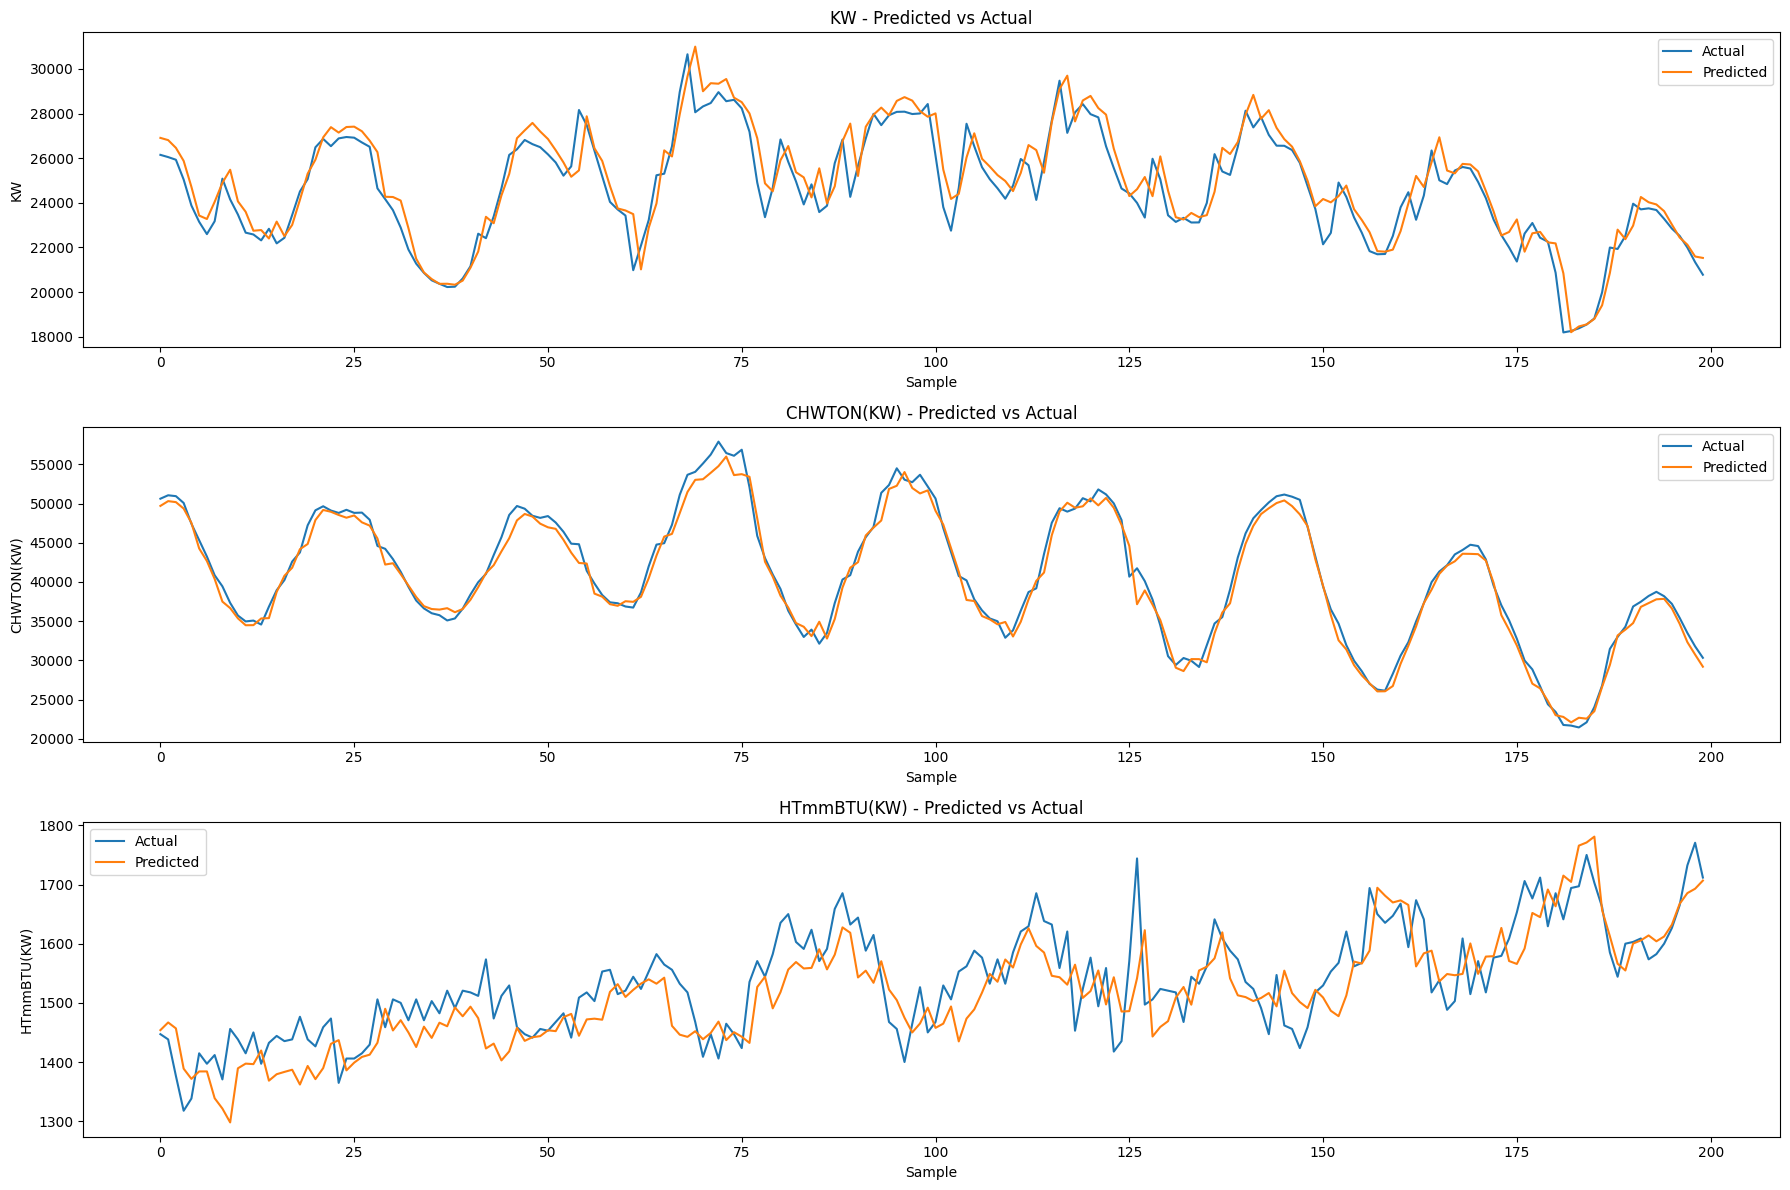

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Combine the inverse-transformed predictions and actual values
y_test_true = np.stack([y_test_kw, y_test_chw, y_test_ht], axis=1)
y_test_pred = np.stack([y_pred_kw, y_pred_chw, y_pred_ht], axis=1)

# Define labels
labels = ['KW', 'CHWTON(KW)', 'HTmmBTU(KW)']

# Plot first 200 samples for each target
plt.figure(figsize=(18, 12))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(y_test_true[:200, i], label='Actual')
    plt.plot(y_test_pred[:200, i], label='Predicted')
    plt.title(f'{labels[i]} - Predicted vs Actual')
    plt.xlabel('Sample')
    plt.ylabel(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Compute MAE and RMSE
def evaluate_predictions(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'{label} - MAE: {mae:.2f}, RMSE: {rmse:.2f}')

evaluate_predictions(y_test_kw, y_pred_kw, 'KW')
evaluate_predictions(y_test_chw, y_pred_chw, 'CHWTON(KW)')
evaluate_predictions(y_test_ht, y_pred_ht, 'HTmmBTU(KW)')


KW - MAE: 456.33, RMSE: 675.07
CHWTON(KW) - MAE: 686.34, RMSE: 957.07
HTmmBTU(KW) - MAE: 75.24, RMSE: 101.93


In [25]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_kw = mean_absolute_percentage_error(y_test_kw, y_pred_kw)
mape_chw = mean_absolute_percentage_error(y_test_chw, y_pred_chw)
mape_ht = mean_absolute_percentage_error(y_test_ht, y_pred_ht)

print(f"KW MAPE: {mape_kw:.2f}%")
print(f"CHWTON MAPE: {mape_chw:.2f}%")
print(f"HTmmBTU MAPE: {mape_ht:.2f}%")


KW MAPE: 2.31%
CHWTON MAPE: 3.42%
HTmmBTU MAPE: 3.30%


In [26]:
import tensorflow as tf

# Define the custom weighted loss function
def custom_weighted_loss(y_true, y_pred):
    # Define weights for each output (adjust as needed)
    weights = tf.constant([1.0, 1.0, 1.0])  # Example weights for KW, CHWTON, HTmmBTU

    # Calculate squared errors for each output
    squared_errors = tf.square(y_true - y_pred)

    # Apply weights to the squared errors
    weighted_squared_errors = squared_errors * weights

    # Calculate the mean of the weighted squared errors
    loss = tf.reduce_mean(weighted_squared_errors)

    return loss

# Rebuild and compile the model with the custom loss function
model = build_multi_task_model(input_shape, output_dim)
model.compile(optimizer='adam', loss=custom_weighted_loss)

# Reshape y for training with custom loss
y_train_reshaped_custom_loss = y_train[:, 0, :]
y_val_reshaped_custom_loss = y_val[:, 0, :]

history = model.fit(X_train, y_train_reshaped_custom_loss,
                    validation_data=(X_val, y_val_reshaped_custom_loss),
                    epochs=50,
                    batch_size=64,
                    verbose=1)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.0205 - mae: 0.0806 - val_loss: 0.0039 - val_mae: 0.0456
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.0014 - mae: 0.0276 - val_loss: 0.0023 - val_mae: 0.0340
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0011 - mae: 0.0239 - val_loss: 0.0017 - val_mae: 0.0293
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 9.4764e-04 - mae: 0.0223 - val_loss: 0.0016 - val_mae: 0.0285
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 7.8888e-04 - mae: 0.0202 - val_loss: 0.0019 - val_mae: 0.0305
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 7.4736e-04 - mae: 0.0194 - val_loss: 0.0022 - val_mae: 0.0324
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 6.8842e-04 - mae: 0.0188 - val_loss: 0.0015 - val_mae: 0.0278
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 6.5390e-04 - mae: 0.0182 - val_loss: 0.0016 - val_mae: 0.0274
Epoch 9/50
192/192 ━━━

In [27]:
# Reshape y for training with custom loss
y_train_reshaped_custom_loss = y_train[:, 0, :]
y_val_reshaped_custom_loss = y_val[:, 0, :]

history = model.fit(X_train, y_train_reshaped_custom_loss,
                    validation_data=(X_val, y_val_reshaped_custom_loss),
                    epochs=50,
                    batch_size=64,
                    verbose=1)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 4.1676e-04 - mae: 0.0143 - val_loss: 7.3564e-04 - val_mae: 0.0190
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 4.2094e-04 - mae: 0.0143 - val_loss: 7.2663e-04 - val_mae: 0.0195
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 4.0640e-04 - mae: 0.0140 - val_loss: 6.9338e-04 - val_mae: 0.0196
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 3.9849e-04 - mae: 0.0139 - val_loss: 9.3460e-04 - val_mae: 0.0211
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 3.9889e-04 - mae: 0.0140 - val_loss: 8.3245e-04 - val_mae: 0.0209
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 3.9685e-04 - mae: 0.0138 - val_loss: 7.1722e-04 - val_mae: 0.0187
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 4.1553e-04 - mae: 0.0142 - val_loss: 7.3787e-04 - val_mae: 0.0200
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 4.0284e-04 - mae: 0.0139 - val_loss: 8.1723e-04

In [28]:
import pandas as pd

# Charger les données
metro_data = pd.read_csv('data_set_adjusted.csv')

# S'assurer que la colonne datetime est bien au format datetime
metro_data['datetime'] = pd.to_datetime(metro_data['datetime'])

# Mettre datetime comme index (optionnel mais pratique)
metro_data = metro_data.set_index('datetime')

#  Ajout des colonnes temporelles utiles
metro_data['Hour'] = metro_data.index.hour
metro_data['DayOfWeek'] = metro_data.index.dayofweek
metro_data['Month'] = metro_data.index.month

# (Facultatif) Afficher pour vérifier
print(metro_data.head())

# PLUS BESOIN de faire :
# metro_data['Minute'] = ...
# metro_data = metro_data[metro_data['Minute'] != 30]

# Tu peux ensuite continuer la préparation du dataset :
# - normalisation / standardisation
# - création des séquences temporelles
# - split train / val / test

# Exemple : normalisation
from sklearn.preprocessing import StandardScaler

features = metro_data.columns  # toutes les colonnes sauf target, ou choisis celles que tu veux
scaler = StandardScaler()
metro_data_scaled = pd.DataFrame(scaler.fit_transform(metro_data),
                                 columns=features,
                                 index=metro_data.index)

# Vérifier
print(metro_data_scaled.head())


                           KW   CHWTON   CHWTON(KW)  HTmmBTU  HTmmBTU(KW)  \
datetime                                                                    
2018-01-01 00:00:00  17007.47  2021.27  7117.147887    13.17  3873.529412   
2018-01-01 01:00:00  16742.88  1841.30  6483.450704    15.24  4482.352941   
2018-01-01 02:00:00  16874.22  1772.96  6242.816901    16.36  4811.764706   
2018-01-01 03:00:00  16892.98  1736.67  6115.035211    16.03  4714.705882   
2018-01-01 04:00:00  16939.45  1706.68  6009.436620    15.63  4597.058824   

                     Combined mmBTU  Combined mmBTU(KW)     KW_PF  CHWTON_PF  \
datetime                                                                       
2018-01-01 00:00:00           95.46         28076.47059  0.605755   0.253492   
2018-01-01 01:00:00           94.46         27782.35294  0.602644   0.233366   
2018-01-01 02:00:00           95.22         28005.88235  0.602524   0.222911   
2018-01-01 03:00:00           94.51         27797.05882  0.6

In [29]:
data['Hour'] = data.index.hour
data['Day'] = data.index.dayofweek
data['Month'] = data.index.month
data['WeekOfYear'] = data.index.isocalendar().week.astype(int)
data['WeekOfYear_scaled'] = data['WeekOfYear'] / 52.0
data['Year'] = data.index.year

print(data.head())


                      CHWTON  HTmmBTU  Combined mmBTU  Combined mmBTU(KW)  \
datetime                                                                    
2018-01-01 00:00:00  2021.27    13.17           95.46         28076.47059   
2018-01-01 01:00:00  1841.30    15.24           94.46         27782.35294   
2018-01-01 02:00:00  1772.96    16.36           95.22         28005.88235   
2018-01-01 03:00:00  1736.67    16.03           94.51         27797.05882   
2018-01-01 04:00:00  1706.68    15.63           93.91         27620.58824   

                        KW_PF  CHWTON_PF  HTmmBTU_PF  DHI  DNI  GHI  ...  \
datetime                                                             ...   
2018-01-01 00:00:00  0.605755   0.253492    0.137964  0.0  0.0  0.0  ...   
2018-01-01 01:00:00  0.602644   0.233366    0.161338  0.0  0.0  0.0  ...   
2018-01-01 02:00:00  0.602524   0.222911    0.171813  0.0  0.0  0.0  ...   
2018-01-01 03:00:00  0.607725   0.219989    0.169612  0.0  0.0  0.0  ...   
2018

In [30]:
# Vérifier les valeurs uniques pour être sûr
print("Valeurs uniques de Day :", data['Day'].unique())

# Remplacer les 0 (ou valeurs invalides) par 1, qui est valide
data.loc[data['Day'] == 0, 'Day'] = 1


Valeurs uniques de Day : [0 1 2 3 4 5 6]


In [31]:
print(metro_data.columns)


Index(['KW', 'CHWTON', 'CHWTON(KW)', 'HTmmBTU', 'HTmmBTU(KW)',
       'Combined mmBTU', 'Combined mmBTU(KW)', 'KW_PF', 'CHWTON_PF',
       'HTmmBTU_PF', 'DHI', 'DNI', 'GHI', 'Dew Point', 'Wind Speed',
       'Precipitable Water', 'Wind Direction', 'Relative Humidity',
       'Temperature', 'Pressure', 'Hour', 'DayOfWeek', 'Month'],
      dtype='object')


In [32]:
print("Valeurs uniques de Day dans metro_data :", metro_data['DayOfWeek'].unique())
metro_data.loc[metro_data['DayOfWeek'] == 0, 'DayOfWeek'] = 1


Valeurs uniques de Day dans metro_data : [0 1 2 3 4 5 6]


In [33]:
metro_data['Hour'] = metro_data.index.hour
metro_data['Day'] = metro_data.index.dayofweek
metro_data['Month'] = metro_data.index.month
metro_data['WeekOfYear'] = metro_data.index.isocalendar().week.astype(int)
metro_data['WeekOfYear_scaled'] = metro_data['WeekOfYear'] / 52.0
metro_data['Year'] = metro_data.index.year

print(metro_data.head())

                           KW   CHWTON   CHWTON(KW)  HTmmBTU  HTmmBTU(KW)  \
datetime                                                                    
2018-01-01 00:00:00  17007.47  2021.27  7117.147887    13.17  3873.529412   
2018-01-01 01:00:00  16742.88  1841.30  6483.450704    15.24  4482.352941   
2018-01-01 02:00:00  16874.22  1772.96  6242.816901    16.36  4811.764706   
2018-01-01 03:00:00  16892.98  1736.67  6115.035211    16.03  4714.705882   
2018-01-01 04:00:00  16939.45  1706.68  6009.436620    15.63  4597.058824   

                     Combined mmBTU  Combined mmBTU(KW)     KW_PF  CHWTON_PF  \
datetime                                                                       
2018-01-01 00:00:00           95.46         28076.47059  0.605755   0.253492   
2018-01-01 01:00:00           94.46         27782.35294  0.602644   0.233366   
2018-01-01 02:00:00           95.22         28005.88235  0.602524   0.222911   
2018-01-01 03:00:00           94.51         27797.05882  0.6

In [34]:
print(metro_data.columns)


Index(['KW', 'CHWTON', 'CHWTON(KW)', 'HTmmBTU', 'HTmmBTU(KW)',
       'Combined mmBTU', 'Combined mmBTU(KW)', 'KW_PF', 'CHWTON_PF',
       'HTmmBTU_PF', 'DHI', 'DNI', 'GHI', 'Dew Point', 'Wind Speed',
       'Precipitable Water', 'Wind Direction', 'Relative Humidity',
       'Temperature', 'Pressure', 'Hour', 'DayOfWeek', 'Month', 'Day',
       'WeekOfYear', 'WeekOfYear_scaled', 'Year'],
      dtype='object')


In [35]:
# For data
data['datetime'] = data['Year'].astype(str) + '-' + \
                   data['Month'].astype(str).str.zfill(2) + '-' + \
                   data['Day'].astype(str).str.zfill(2) + '-' + \
                   data['Hour'].astype(str).str.zfill(2)

data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d-%H')

# For metro_data
metro_data['datetime'] = metro_data['Year'].astype(str) + '-' + \
                         metro_data['Month'].astype(str).str.zfill(2) + '-' + \
                         metro_data['DayOfWeek'].astype(str).str.zfill(2) + '-' + \
                         metro_data['Hour'].astype(str).str.zfill(2)

metro_data['datetime'] = pd.to_datetime(metro_data['datetime'], format='%Y-%m-%d-%H')


In [36]:
data = data.set_index('datetime')
metro_data = metro_data.set_index('datetime')


In [37]:
data = data[['KW','HTmmBTU','CHWTON']]
Qu_1 = data.quantile(0.25)
Qu_3 = data.quantile(0.75)
IQR = Qu_3 - Qu_1
((data<(Qu_1 - 3.0 * IQR)) | (data>(Qu_3 + 2.0 * IQR))).sum()

,0
KW,7
HTmmBTU,49
CHWTON,0


In [38]:
data[((data < (Qu_1 - 2.0 * IQR)) | (data > (Qu_3 + 2.0 * IQR)))] = np.nan
data.loc[data['KW'] == 0, 'KW'] = np.nan
data.loc[data['HTmmBTU'] == 0, 'HTmmBTU'] = np.nan
data.loc[data['CHWTON'] == 0, 'CHWTON'] = np.nan

data.ffill(inplace=True)


In [39]:
merge=pd.merge(data,metro_data, how='inner', left_index=True, right_index=True)


In [40]:
print("Colonnes disponibles :", merge.columns.tolist())


Colonnes disponibles : ['KW_x', 'HTmmBTU_x', 'CHWTON_x', 'KW_y', 'CHWTON_y', 'CHWTON(KW)', 'HTmmBTU_y', 'HTmmBTU(KW)', 'Combined mmBTU', 'Combined mmBTU(KW)', 'KW_PF', 'CHWTON_PF', 'HTmmBTU_PF', 'DHI', 'DNI', 'GHI', 'Dew Point', 'Wind Speed', 'Precipitable Water', 'Wind Direction', 'Relative Humidity', 'Temperature', 'Pressure', 'Hour', 'DayOfWeek', 'Month', 'Day', 'WeekOfYear', 'WeekOfYear_scaled', 'Year']


In [41]:
data = merge
data['HTmmBTU_x'] = data['HTmmBTU_x'] * 293.07
data['CHWTON_x'] = data['CHWTON_x'] * 3.52

In [42]:

data['KW_last_hour'] = data['KW_x'].shift()
data['HTmmBTU_last_hour'] = data['HTmmBTU_x'].shift()
data['CHWTON_last_hour'] = data['CHWTON_x'].shift()

data['KW_last_2_hour'] = data['KW_x'].shift(2)
data['HTmmBTU_last_2_hour'] = data['HTmmBTU_x'].shift(2)
data['CHWTON_last_2_hour'] = data['CHWTON_x'].shift(2)

data['KW_last_day'] = data['KW_x'].shift(24)
data['HTmmBTU_last_day'] = data['HTmmBTU_x'].shift(24)
data['CHWTON_last_day'] = data['CHWTON_x'].shift(24)

data['KW_last_week'] = data['KW_x'].shift(168)
data['HTmmBTU_last_week'] = data['HTmmBTU_x'].shift(168)
data['CHWTON_last_week'] = data['CHWTON_x'].shift(168)

data['KW_last_year'] = data.groupby([data.index.month,data.index.day,data.index.hour])['KW_x'].shift()
data['HTmmBTU_last_year'] = data.groupby([data.index.month,data.index.day,data.index.hour])['HTmmBTU_x'].shift()
data['CHWTON_last_year'] = data.groupby([data.index.month,data.index.day,data.index.hour])['CHWTON_x'].shift()


data.bfill(inplace=True)


In [43]:

from sklearn.preprocessing import MinMaxScaler
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd

# Extrait des données par saison
spring_data = data[(data['Month']>2) & (data['Month']<6)].copy()
spring_data.name = 'spring_data'

summer_data = data[(data['Month']>5) & (data['Month']<9)].copy()
summer_data.name = 'summer_data'

autumn_data = data[(data['Month']>8) & (data['Month']<12)].copy()
autumn_data.name = 'autumn_data'

winter_data = data[(data['Month']>11) | (data['Month']<3)].copy()
winter_data.name = 'winter_data'

# Renommer les colonnes pour qu'elles correspondent aux noms attendus
for df in [spring_data, summer_data, autumn_data, winter_data]:
    df.rename(columns={
        'KW_x': 'KW',
        'HTmmBTU_x': 'HTmmBTU',
        'CHWTON_x': 'CHWTON'
    }, inplace=True)

# --------------------------------------------------
# rolling_window (garde ta fonction actuelle)
def rolling_window(array_data_real, input_size, output_size, offset, out=[], inp=['C','H','E']):
    '''
    Découpe les données en fenêtres temporelles
    '''
    array_data = array_data_real.copy(deep=True)
    scaler = MinMaxScaler()
    scaler = scaler.fit(array_data)
    array_data_scaled = pd.DataFrame(scaler.transform(array_data), columns=array_data.columns)

    if ('C' not in inp) & ('C' not in out):
        array_data_scaled.drop(['CHWTON', 'CHWTON_last_hour', 'CHWTON_last_2_hour',
                                'CHWTON_last_day', 'CHWTON_last_week', 'CHWTON_last_year'], axis=1, inplace=True)
    if ('H' not in inp) & ('H' not in out):
        array_data_scaled.drop(['HTmmBTU', 'HTmmBTU_last_hour', 'HTmmBTU_last_2_hour',
                                'HTmmBTU_last_day', 'HTmmBTU_last_week', 'HTmmBTU_last_year'], axis=1, inplace=True)
    if ('E' not in inp) & ('E' not in out):
        array_data_scaled.drop(['KW', 'KW_last_hour', 'KW_last_2_hour',
                                'KW_last_day', 'KW_last_week', 'KW_last_year'], axis=1, inplace=True)

    data_idx = sliding_window_view(
        np.arange(array_data_scaled.shape[0]).reshape(-1),
        window_shape=input_size
    )[::offset][:-1]

    data = array_data_scaled.to_numpy()[data_idx]

    if 'C' in out:
        out_array = array_data_scaled['CHWTON'].to_numpy()
    elif 'H' in out:
        out_array = array_data_scaled['HTmmBTU'].to_numpy()
    elif 'E' in out:
        out_array = array_data_scaled['KW'].to_numpy()
    else:
        raise ValueError("Specify at least one output in 'out'.")

    labels = sliding_window_view(out_array[input_size:].reshape(-1), window_shape=output_size)[::offset]

    return data.astype(np.float64), labels.astype(np.float64), scaler, array_data




In [44]:
##Autumn Data

tr_id = int((autumn_data.shape[0]*0.80)/24)*24
val_id = int((autumn_data.shape[0]*0.90)/24)*24
tra_data = autumn_data.iloc[:tr_id,:]
val_data = autumn_data.iloc[tr_id:val_id,:]
tes_data = autumn_data.iloc[val_id:,:]




In [45]:

heat_tra_data_sli,heat_tra_lab,heat_tra_sca,heat_tra_stan = rolling_window(tra_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['H'],inp=['C','H','E'])
heat_val_data_sli,heat_val_lab,heat_val_sca,heat_val_stan = rolling_window(val_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['H'],inp=['C','H','E'])
heat_tes_data_sli,heat_tes_lab,heat_test_scaler,heat_tes_stan = rolling_window(tes_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['H'],inp=['C','H','E'])

## Cooling Data Summer

cool_tra_data_sli,cool_tra_lab,cool_tra_sca,col_tra_stan = rolling_window(tra_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['C'],inp=['C','H','E'])
cool_val_data_sli,cool_val_lab,cool_val_sca,cool_val_stan = rolling_window(val_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['C'],inp=['C','H','E'])
cool_tes_data_sli,cool_tes_lab,cool_test_scaler,cool_tes_stan = rolling_window(tes_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['C'],inp=['C','H','E'])

## Electric Data Summer

elec_tra_data_sli,elec_tra_lab,elec_tra_sca,elec_tra_stan = rolling_window(tra_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['E'],inp=['C','H','E'])
elec_val_data_sli,elec_val_lab,elec_val_sca,elec_val_stan = rolling_window(val_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['E'],inp=['C','H','E'])
elec_tes_data_sli,elec_tes_lab,elec_test_scaler,elec_tes_stan = rolling_window(tes_data,input_size=TRAIN_STEPS,output_size=OUTPUT_STEPS,offset=OFFSET,out=['E'],inp=['C','H','E'])

In [46]:
def array_to_dataset(x1,y1,x2,y2,x3,y3,b_size):

    '''
    Takes inputs and labels for 3 different datasets and returns a dataloader object

    x1,y1 = heat

    x2,y2 = cool

    x3,y3 = elec
    '''

    x1_tensor = torch.from_numpy(x1).float()

    y1_tensor = torch.from_numpy(y1).float()

    x2_tensor = torch.from_numpy(x2).float()

    y2_tensor = torch.from_numpy(y2).float()

    x3_tensor = torch.from_numpy(x3).float()

    y3_tensor = torch.from_numpy(y3).float()

    dataset = TensorDataset(x1_tensor,y1_tensor,x2_tensor,y2_tensor,x3_tensor,y3_tensor)

    my_dataloader = DataLoader(dataset,batch_size=b_size)

    return my_dataloader

In [47]:
train_dataloader = array_to_dataset(heat_tra_data_sli,heat_tra_lab,cool_tra_data_sli,cool_tra_lab,elec_tra_data_sli,elec_tra_lab,b_size=BATCH_SIZE)

In [48]:
val_dataloader = array_to_dataset(heat_val_data_sli,heat_val_lab,cool_val_data_sli,cool_val_lab,elec_val_data_sli,elec_val_lab,b_size=BATCH_SIZE)

In [49]:
tes_dataloader = array_to_dataset(heat_tes_data_sli,heat_tes_lab,cool_tes_data_sli,cool_tes_lab,elec_tes_data_sli,elec_tes_lab,b_size=BATCH_SIZE)

In [50]:
class my_model(torch.nn.Module):

    def __init__(self, train_steps, heat_feature, cool_feature, elec_feature, lstm_dim):
        super().__init__()

        self.train_steps = train_steps
        self.heat_feature = heat_feature
        self.cool_feature = cool_feature
        self.elec_feature = elec_feature
        self.lstm_dim = lstm_dim

        self.input_1 = TCN(
            num_inputs=heat_feature,
            num_channels=[32, self.lstm_dim],
            kernel_size=8,
            dropout=0.2,
            input_shape='NLC',
            use_skip_connections=True,
            activation='leaky_relu'
        )

        self.input_2 = TCN(
            num_inputs=cool_feature,
            num_channels=[32, self.lstm_dim],
            kernel_size=8,
            dropout=0.2,
            input_shape='NLC',
            use_skip_connections=True,
            activation='leaky_relu'
        )

        self.input_3 = TCN(
            num_inputs=elec_feature,
            num_channels=[32, self.lstm_dim],
            kernel_size=8,
            dropout=0.2,
            input_shape='NLC',
            use_skip_connections=True,
            activation='leaky_relu'
        )

        self.flatten_layer = nn.Flatten(start_dim=1)
        self.fully = nn.Linear(3*self.lstm_dim, 3)
        self.relu = nn.LeakyReLU()

    def forward(self, heat_input, cool_input, elec_input):
        out_hea = self.input_1(heat_input)
        out_coo = self.input_2(cool_input)
        out_ele = self.input_3(elec_input)

        concat_layer = torch.cat((
            self.flatten_layer(out_hea[:, -1, :]),
            self.flatten_layer(out_coo[:, -1, :]),
            self.flatten_layer(out_ele[:, -1, :])
        ), 1)

        feature_sharing_layer = self.fully(concat_layer)
        final_output = self.relu(feature_sharing_layer)

        output_heat = final_output[:, 0].unsqueeze(1)
        output_cool = final_output[:, 1].unsqueeze(1)
        output_elec = final_output[:, 2].unsqueeze(1)

        return output_heat, output_cool, output_elec

HEA_FEA = int(heat_tra_data_sli.shape[2])
COO_FEA = int(cool_tra_data_sli.shape[2])
ELE_FEA = int(elec_tra_data_sli.shape[2])


In [51]:
!pip install torchinfo

In [52]:
from torchinfo import summary

model = my_model(TRAIN_STEPS, HEA_FEA, COO_FEA, ELE_FEA, LSTM_DIM)

summary(model, input_size=[
    (BATCH_SIZE, TRAIN_STEPS, HEA_FEA),   # heat_input
    (BATCH_SIZE, TRAIN_STEPS, COO_FEA),   # cool_input
    (BATCH_SIZE, TRAIN_STEPS, ELE_FEA)    # elec_input
])


Layer (type:depth-idx)                                       Output Shape              Param #
my_model                                                     [32, 1]                   --
├─TCN: 1-1                                                   [32, 168, 64]             --
│    └─ModuleList: 2-3                                       --                        (recursive)
│    │    └─TemporalBlock: 3-1                               [32, 32, 168]             21,312
│    └─ModuleList: 2-2                                       --                        --
│    │    └─Conv1d: 3-2                                      [32, 64, 168]             2,112
│    └─ModuleList: 2-3                                       --                        (recursive)
│    │    └─TemporalBlock: 3-3                               [32, 64, 168]             51,520
│    └─LeakyReLU: 2-4                                        [32, 64, 168]             --
├─TCN: 1-2                                                   [32, 

In [53]:
model = my_model(TRAIN_STEPS,HEA_FEA,COO_FEA,ELE_FEA,LSTM_DIM)
summary(model)

Layer (type:depth-idx)                                       Param #
my_model                                                     --
├─TCN: 1-1                                                   --
│    └─ModuleList: 2-1                                       --
│    │    └─Conv1d: 3-1                                      2,112
│    └─LeakyReLU: 2-2                                        --
│    └─ModuleList: 2-3                                       --
│    │    └─TemporalBlock: 3-2                               21,312
│    │    └─TemporalBlock: 3-3                               51,520
├─TCN: 1-2                                                   --
│    └─ModuleList: 2-4                                       --
│    │    └─Conv1d: 3-4                                      2,112
│    └─LeakyReLU: 2-5                                        --
│    └─ModuleList: 2-6                                       --
│    │    └─TemporalBlock: 3-5                               21,312
│    │    └─Tempo

In [54]:
def train_model(model,train_dataloader,val_dataloader,seq_length,n_epochs):

    history = dict(train=[],val=[])

    best_loss = 10000

    mb = master_bar(range(1,n_epochs+1))

    for epoch in mb:

        model = model.train()

        train_losses = []

        for TrainXHeat,TrainYHeat,TrainXCool,TrainYCool,TrainXElec,TrainYElec in tqdm(train_dataloader):

            seq_inp_heat = TrainXHeat.to(device)

            seq_true_heat = TrainYHeat.to(device)

            seq_inp_cool = TrainXCool.to(device)

            seq_true_cool = TrainYCool.to(device)

            seq_inp_elec = TrainXElec.to(device)

            seq_true_elec = TrainYElec.to(device)

            optimizer.zero_grad()

            seq_pred_heat,seq_pred_cool,seq_pred_elec = model(seq_inp_heat,seq_inp_cool,seq_inp_elec)

            loss_heat = criterion(seq_pred_heat,seq_true_heat)

            loss_cool = criterion(seq_pred_cool,seq_true_cool)


            loss_elec = criterion(seq_pred_elec,seq_true_elec)

            loss = loss_heat + loss_cool + loss_elec

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []

        loss_cools = []

        loss_heats = []

        model = model.eval()

        with torch.no_grad():

            for ValidXHeat,ValidYHeat,ValidXCool,ValidYCool,ValidXElec,ValidYElec in val_dataloader:

                seq_inp_heat = ValidXHeat.to(device)

                seq_true_heat = ValidYHeat.to(device)

                seq_inp_cool = ValidXCool.to(device)

                seq_true_cool = ValidYCool.to(device)

                seq_inp_elec = ValidXElec.to(device)

                seq_true_elec = ValidYElec.to(device)

                seq_pred_heat,seq_pred_cool,seq_pred_elec = model(seq_inp_heat,seq_inp_cool,seq_inp_elec)

                loss_heat = criterion(seq_pred_heat,seq_true_heat)

                loss_cool = criterion(seq_pred_cool,seq_true_cool)

                loss_elec = criterion(seq_pred_elec,seq_true_elec)

                loss = loss_heat + loss_cool + loss_elec

                val_losses.append(loss.item())

                loss_cools.append(loss_cool.item())

                loss_heats.append(loss_heat.item())


        train_loss = np.mean(train_losses)

        val_loss = np.mean(val_losses)

        loss_cool_mean = np.mean(loss_cools)

        loss_heat_mean = np.mean(loss_heats)

        history['train'].append(train_loss)

        history['val'].append(val_loss)

        if val_loss < best_loss:

            best_loss = val_loss

            torch.save(model.state_dict(), 'best_model_n_features_GRU_1.pt')

            print("saved best model epoch:",epoch,"val loss is:",val_loss)

            print("cool val loss is:",loss_cool_mean)

            print("heat val loss is:",loss_heat_mean)



        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

        scheduler.step(val_loss)

    #model.load_state_dict(best_model_wts)

    return model.eval(), history

In [55]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-5)
criterion = torch.nn.MSELoss().to(device)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 5e-3, eta_min=1e-8, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=10, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [56]:
model, history = train_model(
  model,
  train_dataloader,
  val_dataloader,
  seq_length=TRAIN_STEPS,
  n_epochs=MAX_EPOCH, #Train for few epochs as illustration,

)

100%|██████████| 609/609 [02:46<00:00,  3.66it/s]


saved best model epoch: 1 val loss is: 0.08736347034573555
cool val loss is: 0.036543945938723885
heat val loss is: 0.02905495645892289
Epoch 1: train loss 0.02678467225121282 val loss 0.08736347034573555


100%|██████████| 609/609 [02:27<00:00,  4.13it/s]


saved best model epoch: 2 val loss is: 0.05880419445586287
cool val loss is: 0.027120538651716843
heat val loss is: 0.019210482238526713
Epoch 2: train loss 0.010834749612945005 val loss 0.05880419445586287


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


saved best model epoch: 3 val loss is: 0.04643109513239728
cool val loss is: 0.02244645558433452
heat val loss is: 0.014872831792066185
Epoch 3: train loss 0.006808753245225717 val loss 0.04643109513239728


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


saved best model epoch: 4 val loss is: 0.04105654398962441
cool val loss is: 0.020675043961091433
heat val loss is: 0.012596449708022798
Epoch 4: train loss 0.00502929285230583 val loss 0.04105654398962441


100%|██████████| 609/609 [02:28<00:00,  4.09it/s]


saved best model epoch: 5 val loss is: 0.036172775849182576
cool val loss is: 0.018719679338876933
heat val loss is: 0.010491012218052573
Epoch 5: train loss 0.004001100229715687 val loss 0.036172775849182576


100%|██████████| 609/609 [02:28<00:00,  4.10it/s]


saved best model epoch: 6 val loss is: 0.03224871234528513
cool val loss is: 0.017560846917654596
heat val loss is: 0.008323765735743413
Epoch 6: train loss 0.003295725825405565 val loss 0.03224871234528513


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


saved best model epoch: 7 val loss is: 0.02992926266354819
cool val loss is: 0.016201250790294983
heat val loss is: 0.007775073316426844
Epoch 7: train loss 0.002876365605867139 val loss 0.02992926266354819


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


saved best model epoch: 8 val loss is: 0.027852717398976285
cool val loss is: 0.015570871549344802
heat val loss is: 0.006808201104124439
Epoch 8: train loss 0.0025692609749919442 val loss 0.027852717398976285


100%|██████████| 609/609 [02:27<00:00,  4.13it/s]


saved best model epoch: 9 val loss is: 0.026269754550109308
cool val loss is: 0.014740207790358303
heat val loss is: 0.0061780150224674596
Epoch 9: train loss 0.0023203559436037074 val loss 0.026269754550109308


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


saved best model epoch: 10 val loss is: 0.02487141488947802
cool val loss is: 0.014104458361139728
heat val loss is: 0.005823312200744921
Epoch 10: train loss 0.002111532588620106 val loss 0.02487141488947802


100%|██████████| 609/609 [02:27<00:00,  4.13it/s]


saved best model epoch: 11 val loss is: 0.023633385322884552
cool val loss is: 0.013369831772352982
heat val loss is: 0.005579256636135849
Epoch 11: train loss 0.001989529483889693 val loss 0.023633385322884552


100%|██████████| 609/609 [02:27<00:00,  4.13it/s]


saved best model epoch: 12 val loss is: 0.02284686581697315
cool val loss is: 0.013395099159323662
heat val loss is: 0.004809424188149731
Epoch 12: train loss 0.0018370935118666198 val loss 0.02284686581697315


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


saved best model epoch: 13 val loss is: 0.02218023222586554
cool val loss is: 0.013045547585028948
heat val loss is: 0.00487218158822442
Epoch 13: train loss 0.001765636993162655 val loss 0.02218023222586554


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


saved best model epoch: 14 val loss is: 0.02186602719464443
cool val loss is: 0.01300923647633883
heat val loss is: 0.004507558106625866
Epoch 14: train loss 0.0017049346617705912 val loss 0.02186602719464443


100%|██████████| 609/609 [02:27<00:00,  4.12it/s]


Epoch 15: train loss 0.0016052226836285408 val loss 0.02193770765249307


100%|██████████| 609/609 [02:28<00:00,  4.11it/s]


saved best model epoch: 16 val loss is: 0.02057739158691321
cool val loss is: 0.01230955832256263
heat val loss is: 0.004139230967363498
Epoch 16: train loss 0.0015281597862027018 val loss 0.02057739158691321


100%|██████████| 609/609 [02:28<00:00,  4.11it/s]


Epoch 17: train loss 0.0014894974424866179 val loss 0.020741813683546044


100%|██████████| 609/609 [02:27<00:00,  4.12it/s]


saved best model epoch: 18 val loss is: 0.020064347957183298
cool val loss is: 0.012198832373542245
heat val loss is: 0.003760772560175004
Epoch 18: train loss 0.0014456670499240064 val loss 0.020064347957183298


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


Epoch 19: train loss 0.0013777972570825398 val loss 0.020116583356866613


100%|██████████| 609/609 [02:28<00:00,  4.10it/s]


saved best model epoch: 20 val loss is: 0.019343646615096886
cool val loss is: 0.011725233073068213
heat val loss is: 0.0036348648136481643
Epoch 20: train loss 0.0013291485444088245 val loss 0.019343646615096886


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


saved best model epoch: 21 val loss is: 0.01875764710065495
cool val loss is: 0.011320428466003958
heat val loss is: 0.003478881076767316
Epoch 21: train loss 0.0013065500614426002 val loss 0.01875764710065495


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


saved best model epoch: 22 val loss is: 0.017024764034431428
cool val loss is: 0.01002544636382178
heat val loss is: 0.0033847113380842428
Epoch 22: train loss 0.0012837963561834814 val loss 0.017024764034431428


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


saved best model epoch: 23 val loss is: 0.016668594203009788
cool val loss is: 0.00999414615054977
heat val loss is: 0.003200459310189924
Epoch 23: train loss 0.0012546940045263038 val loss 0.016668594203009788


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


saved best model epoch: 24 val loss is: 0.016249250192130502
cool val loss is: 0.009484564857201703
heat val loss is: 0.003123539777637537
Epoch 24: train loss 0.0012069155609469146 val loss 0.016249250192130502


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


saved best model epoch: 25 val loss is: 0.015881900227719195
cool val loss is: 0.009019001207586067
heat val loss is: 0.002992723340664977
Epoch 25: train loss 0.0011839245409515115 val loss 0.015881900227719195


100%|██████████| 609/609 [02:27<00:00,  4.13it/s]


Epoch 26: train loss 0.0011696993437945867 val loss 0.016008935613273125


100%|██████████| 609/609 [02:27<00:00,  4.13it/s]


saved best model epoch: 27 val loss is: 0.015691353923304834
cool val loss is: 0.008613337187853176
heat val loss is: 0.003082104937574412
Epoch 27: train loss 0.0011281847729854597 val loss 0.015691353923304834


100%|██████████| 609/609 [02:27<00:00,  4.13it/s]


saved best model epoch: 28 val loss is: 0.015251958474335778
cool val loss is: 0.00832268926994099
heat val loss is: 0.003294725255626771
Epoch 28: train loss 0.0011026096554010057 val loss 0.015251958474335778


100%|██████████| 609/609 [02:27<00:00,  4.13it/s]


saved best model epoch: 29 val loss is: 0.014384116505324427
cool val loss is: 0.007609592837980017
heat val loss is: 0.003329291118764862
Epoch 29: train loss 0.0011019283898791438 val loss 0.014384116505324427


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


saved best model epoch: 30 val loss is: 0.013672063457003484
cool val loss is: 0.00733637809834262
heat val loss is: 0.003221515983265514
Epoch 30: train loss 0.0010981856372107236 val loss 0.013672063457003484


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


Epoch 31: train loss 0.0010728356968944094 val loss 0.013872520070031492


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


saved best model epoch: 32 val loss is: 0.013503163056965504
cool val loss is: 0.0076362384619036066
heat val loss is: 0.0027409234858674202
Epoch 32: train loss 0.00106015300289506 val loss 0.013503163056965504


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


saved best model epoch: 33 val loss is: 0.012965623897293376
cool val loss is: 0.007208488884821741
heat val loss is: 0.00233284421523826
Epoch 33: train loss 0.001014305578490447 val loss 0.012965623897293376


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


saved best model epoch: 34 val loss is: 0.012201871370456906
cool val loss is: 0.006567269710810958
heat val loss is: 0.0025134401653809212
Epoch 34: train loss 0.0009952168012774215 val loss 0.012201871370456906


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


Epoch 35: train loss 0.0009815335940024457 val loss 0.012292297162477754


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


saved best model epoch: 36 val loss is: 0.01180997843362598
cool val loss is: 0.006471154482925259
heat val loss is: 0.0025621325185056776
Epoch 36: train loss 0.000970500811611605 val loss 0.01180997843362598


100%|██████████| 609/609 [02:25<00:00,  4.19it/s]


saved best model epoch: 37 val loss is: 0.011381403133984551
cool val loss is: 0.006386930186838274
heat val loss is: 0.00247345174405685
Epoch 37: train loss 0.0009667291980269648 val loss 0.011381403133984551


100%|██████████| 609/609 [02:25<00:00,  4.19it/s]


saved best model epoch: 38 val loss is: 0.010553373911534436
cool val loss is: 0.006176855319709931
heat val loss is: 0.0020919964226777665
Epoch 38: train loss 0.0009598455618155512 val loss 0.010553373911534436


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


saved best model epoch: 39 val loss is: 0.010199203012032539
cool val loss is: 0.005920808313627883
heat val loss is: 0.0021497516354429536
Epoch 39: train loss 0.0009703962344998167 val loss 0.010199203012032539


100%|██████████| 609/609 [02:28<00:00,  4.11it/s]


Epoch 40: train loss 0.0009524694642050908 val loss 0.010270135642106956


100%|██████████| 609/609 [02:28<00:00,  4.10it/s]


saved best model epoch: 41 val loss is: 0.009948507022474788
cool val loss is: 0.005573945320874272
heat val loss is: 0.0021047530665075304
Epoch 41: train loss 0.0009364703599319982 val loss 0.009948507022474788


100%|██████████| 609/609 [02:28<00:00,  4.11it/s]


Epoch 42: train loss 0.0009287915013859367 val loss 0.010479452866194252


100%|██████████| 609/609 [02:27<00:00,  4.13it/s]


Epoch 43: train loss 0.000917357493014945 val loss 0.011436310997750197


100%|██████████| 609/609 [02:27<00:00,  4.13it/s]


Epoch 44: train loss 0.000913513928285933 val loss 0.011541675080985038


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


Epoch 45: train loss 0.0009080639716850637 val loss 0.011222227943815395


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 46: train loss 0.0009148135304922003 val loss 0.011125508731412184


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


Epoch 47: train loss 0.0009059155984855852 val loss 0.011127279251619862


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 48: train loss 0.0008962793440205521 val loss 0.011516487769161662


100%|██████████| 609/609 [02:27<00:00,  4.13it/s]


Epoch 49: train loss 0.0008912929205909411 val loss 0.01285081115202047


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


Epoch 50: train loss 0.0008782889727523706 val loss 0.013213355828257691


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


Epoch 51: train loss 0.0008776452362495138 val loss 0.012510291245740114


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


Epoch 52: train loss 0.0008675184317878624 val loss 0.01236370219299311


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 53: train loss 0.0010524156458170438 val loss 0.01259404598062651


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


Epoch 54: train loss 0.0010063572225364672 val loss 0.012149069898037447


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


Epoch 55: train loss 0.0008843844783341753 val loss 0.011134837684544941


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


Epoch 56: train loss 0.0008338199050174506 val loss 0.010692712928478917


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


Epoch 57: train loss 0.0008097894771054405 val loss 0.0102570359433432


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


Epoch 58: train loss 0.000788754543738955 val loss 0.010012654810755825


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


saved best model epoch: 59 val loss is: 0.009899264560469115
cool val loss is: 0.0059518734358587405
heat val loss is: 0.0016623901236824975
Epoch 59: train loss 0.0007666125392997393 val loss 0.009899264560469115


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


saved best model epoch: 60 val loss is: 0.009602687641745433
cool val loss is: 0.005678720681721138
heat val loss is: 0.0016123913893453493
Epoch 60: train loss 0.0007576061951423566 val loss 0.009602687641745433


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


Epoch 61: train loss 0.0007510368905029426 val loss 0.00988153168064956


100%|██████████| 609/609 [02:27<00:00,  4.12it/s]


saved best model epoch: 62 val loss is: 0.009512802228629071
cool val loss is: 0.005618589765314634
heat val loss is: 0.0016278794203875198
Epoch 62: train loss 0.0007467984210836284 val loss 0.009512802228629071


100%|██████████| 609/609 [02:27<00:00,  4.13it/s]


Epoch 63: train loss 0.0007476808576579305 val loss 0.009619687583633803


100%|██████████| 609/609 [02:26<00:00,  4.14it/s]


saved best model epoch: 64 val loss is: 0.009406059016732292
cool val loss is: 0.005425275905711007
heat val loss is: 0.00160972786438328
Epoch 64: train loss 0.0007362515342629045 val loss 0.009406059016732292


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


saved best model epoch: 65 val loss is: 0.00935400197825705
cool val loss is: 0.005305869264702778
heat val loss is: 0.001607321585146969
Epoch 65: train loss 0.0007274445893607303 val loss 0.00935400197825705


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


saved best model epoch: 66 val loss is: 0.009304209156349922
cool val loss is: 0.005374547856465344
heat val loss is: 0.0015657599493958212
Epoch 66: train loss 0.0007269225359132761 val loss 0.009304209156349922


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


saved best model epoch: 67 val loss is: 0.009181145300519548
cool val loss is: 0.0051107749487629105
heat val loss is: 0.0016048045090428786
Epoch 67: train loss 0.000727014309526035 val loss 0.009181145300519548


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 68: train loss 0.0007166147497598248 val loss 0.009357899443582736


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


saved best model epoch: 69 val loss is: 0.009143717050190188
cool val loss is: 0.00510058730974884
heat val loss is: 0.0015621916560727793
Epoch 69: train loss 0.0007111704807714383 val loss 0.009143717050190188


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


Epoch 70: train loss 0.000715211705550894 val loss 0.009185069906784015


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


saved best model epoch: 71 val loss is: 0.009113982002923472
cool val loss is: 0.005071507887300363
heat val loss is: 0.0015566513197376884
Epoch 71: train loss 0.0007050229289386595 val loss 0.009113982002923472


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


saved best model epoch: 72 val loss is: 0.009025270180750845
cool val loss is: 0.0050192027063328875
heat val loss is: 0.0015239490619731238
Epoch 72: train loss 0.0007025833365034116 val loss 0.009025270180750845


100%|██████████| 609/609 [02:32<00:00,  4.00it/s]


saved best model epoch: 73 val loss is: 0.008934697637515556
cool val loss is: 0.004919273184188771
heat val loss is: 0.0014967669531971398
Epoch 73: train loss 0.0006925250411324956 val loss 0.008934697637515556


100%|██████████| 609/609 [02:33<00:00,  3.98it/s]


saved best model epoch: 74 val loss is: 0.008719666220713407
cool val loss is: 0.0048871037611711975
heat val loss is: 0.0014841016359746896
Epoch 74: train loss 0.0006928690350632648 val loss 0.008719666220713407


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


Epoch 75: train loss 0.000691877667499096 val loss 0.008936541285947897


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


saved best model epoch: 76 val loss is: 0.008613958801207546
cool val loss is: 0.004733547435737112
heat val loss is: 0.0015045595234065938
Epoch 76: train loss 0.0006937724108161055 val loss 0.008613958801207546


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 77: train loss 0.0006825835975213894 val loss 0.00868164271944099


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


saved best model epoch: 78 val loss is: 0.008516715894479098
cool val loss is: 0.004461306029649374
heat val loss is: 0.001515868660539531
Epoch 78: train loss 0.0006807298969852277 val loss 0.008516715894479098


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 79: train loss 0.0006826591310892269 val loss 0.008566905786412664


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 80: train loss 0.0006777230217786771 val loss 0.008589263023976754


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 81: train loss 0.0006753351382121914 val loss 0.008535596907475136


100%|██████████| 609/609 [02:26<00:00,  4.14it/s]


Epoch 82: train loss 0.0006698715780197974 val loss 0.008657092917322492


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


Epoch 83: train loss 0.0006668840037782681 val loss 0.008585072407085035


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


saved best model epoch: 84 val loss is: 0.008262170764889257
cool val loss is: 0.004287690669621548
heat val loss is: 0.0015026039648849594
Epoch 84: train loss 0.0006648588219079478 val loss 0.008262170764889257


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


saved best model epoch: 85 val loss is: 0.008189265685763935
cool val loss is: 0.004306408805859974
heat val loss is: 0.0014305088168637464
Epoch 85: train loss 0.0006576802337391926 val loss 0.008189265685763935


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


Epoch 86: train loss 0.0006548696803923066 val loss 0.008285904228816636


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 87: train loss 0.0006498618675111021 val loss 0.008287024166848924


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


saved best model epoch: 88 val loss is: 0.007976206195760623
cool val loss is: 0.0041915759546908606
heat val loss is: 0.0014732592232273116
Epoch 88: train loss 0.000654672094523178 val loss 0.007976206195760623


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 89: train loss 0.0006459187044085757 val loss 0.008144097111653537


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 90: train loss 0.0006444086521892228 val loss 0.008115183490897633


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


saved best model epoch: 91 val loss is: 0.00796929320656798
cool val loss is: 0.0041593052046664525
heat val loss is: 0.0014272935962556705
Epoch 91: train loss 0.000641576943153283 val loss 0.00796929320656798


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 92: train loss 0.0006363380924172123 val loss 0.007989091569066254


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


saved best model epoch: 93 val loss is: 0.007954390839182047
cool val loss is: 0.004075769221445726
heat val loss is: 0.0014540219348822979
Epoch 93: train loss 0.0006333331434397953 val loss 0.007954390839182047


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


saved best model epoch: 94 val loss is: 0.007809036387091813
cool val loss is: 0.0040267718698790604
heat val loss is: 0.0013718639925678468
Epoch 94: train loss 0.0006249805194624334 val loss 0.007809036387091813


100%|██████████| 609/609 [02:29<00:00,  4.08it/s]


saved best model epoch: 95 val loss is: 0.0077635617166783456
cool val loss is: 0.0039540445197619395
heat val loss is: 0.001438493917400289
Epoch 95: train loss 0.0006258875328953965 val loss 0.0077635617166783456


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


Epoch 96: train loss 0.0006263543353611007 val loss 0.007800032738790226


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


saved best model epoch: 97 val loss is: 0.007628355286821413
cool val loss is: 0.003878956797254634
heat val loss is: 0.0013533172710190734
Epoch 97: train loss 0.0006273122674269236 val loss 0.007628355286821413


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


Epoch 98: train loss 0.000620315043326033 val loss 0.007670574363954883


100%|██████████| 609/609 [02:25<00:00,  4.20it/s]


Epoch 99: train loss 0.000620896076593909 val loss 0.007636332496379812


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


saved best model epoch: 100 val loss is: 0.007513640357905792
cool val loss is: 0.0036963616480028983
heat val loss is: 0.001469559518732745
Epoch 100: train loss 0.000611474074253947 val loss 0.007513640357905792


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


saved best model epoch: 101 val loss is: 0.00746959980784191
cool val loss is: 0.0036789899410602325
heat val loss is: 0.0014160297927850883
Epoch 101: train loss 0.0006142925518474653 val loss 0.00746959980784191


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


Epoch 102: train loss 0.0006095785383832426 val loss 0.007560854761524954


100%|██████████| 609/609 [02:25<00:00,  4.19it/s]


saved best model epoch: 103 val loss is: 0.007383297993025432
cool val loss is: 0.003732668186583194
heat val loss is: 0.001458210680236031
Epoch 103: train loss 0.000609556870473941 val loss 0.007383297993025432


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


Epoch 104: train loss 0.0006098859784286431 val loss 0.007394367604218941


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


Epoch 105: train loss 0.0006133182200240751 val loss 0.007433463017352753


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


Epoch 106: train loss 0.000606228710926495 val loss 0.0074904060214369865


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


saved best model epoch: 107 val loss is: 0.007088712329277769
cool val loss is: 0.0034661793308461914
heat val loss is: 0.0013515463259763136
Epoch 107: train loss 0.000610190149526072 val loss 0.007088712329277769


100%|██████████| 609/609 [02:25<00:00,  4.20it/s]


Epoch 108: train loss 0.0006028338335956255 val loss 0.0072924401239207425


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


Epoch 109: train loss 0.0006052689308152276 val loss 0.007116459935787134


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 110: train loss 0.000599108857716501 val loss 0.007350858936357933


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 111: train loss 0.0006025697241358731 val loss 0.007145676988228742


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 112: train loss 0.0006008320406793459 val loss 0.007308295298975686


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


Epoch 113: train loss 0.0005974835017122549 val loss 0.007158213872268486


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


Epoch 114: train loss 0.0005919207532642401 val loss 0.007149381121659341


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


saved best model epoch: 115 val loss is: 0.007035221163985423
cool val loss is: 0.003311752812199605
heat val loss is: 0.0013801573441014625
Epoch 115: train loss 0.0005934337388414603 val loss 0.007035221163985423


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


saved best model epoch: 116 val loss is: 0.006979469075708443
cool val loss is: 0.003280305807695388
heat val loss is: 0.0013445429134056515
Epoch 116: train loss 0.0005918487037809402 val loss 0.006979469075708443


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


Epoch 117: train loss 0.0005898893526365311 val loss 0.007146543959000458


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


Epoch 118: train loss 0.0005855266131705923 val loss 0.007193336785551057


100%|██████████| 609/609 [02:27<00:00,  4.13it/s]


saved best model epoch: 119 val loss is: 0.006959854486113828
cool val loss is: 0.0033039859853387396
heat val loss is: 0.0013477326966595785
Epoch 119: train loss 0.0005841414695975526 val loss 0.006959854486113828


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


saved best model epoch: 120 val loss is: 0.006894925392569146
cool val loss is: 0.003391055847815652
heat val loss is: 0.0013281324394888037
Epoch 120: train loss 0.0005831341342215827 val loss 0.006894925392569146


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


Epoch 121: train loss 0.0005782609556242289 val loss 0.007035501336859953


100%|██████████| 609/609 [02:27<00:00,  4.13it/s]


Epoch 122: train loss 0.0005775429922510061 val loss 0.006921012712862446


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


saved best model epoch: 123 val loss is: 0.006752635476813238
cool val loss is: 0.0031601746110633635
heat val loss is: 0.0013894057944222975
Epoch 123: train loss 0.0005751514527248984 val loss 0.006752635476813238


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


Epoch 124: train loss 0.0005776185041701815 val loss 0.006804862404048133


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 125: train loss 0.0005704020259802287 val loss 0.006780229093338776


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


saved best model epoch: 126 val loss is: 0.006531840455459638
cool val loss is: 0.00315700131613994
heat val loss is: 0.001324058046722914
Epoch 126: train loss 0.0005737042973359568 val loss 0.006531840455459638


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 127: train loss 0.000567061430423376 val loss 0.006697584569337778


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 128: train loss 0.0005692431568156634 val loss 0.006760777924985935


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 129: train loss 0.000574762959109045 val loss 0.006651660923833131


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 130: train loss 0.0005665625328723187 val loss 0.006616235188428416


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


Epoch 131: train loss 0.0005595240790020539 val loss 0.006657841324340552


100%|██████████| 609/609 [02:26<00:00,  4.14it/s]


Epoch 132: train loss 0.0005626188141924837 val loss 0.0066182503619024325


100%|██████████| 609/609 [02:27<00:00,  4.14it/s]


Epoch 133: train loss 0.0005655168368676463 val loss 0.006541241332241852


100%|██████████| 609/609 [02:26<00:00,  4.14it/s]


Epoch 134: train loss 0.0005596282763781496 val loss 0.0066790862862641616


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


saved best model epoch: 135 val loss is: 0.00644247832436425
cool val loss is: 0.003027527778208928
heat val loss is: 0.0012993837931895137
Epoch 135: train loss 0.0005647590478653951 val loss 0.00644247832436425


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


Epoch 136: train loss 0.0005571904910685515 val loss 0.006593191950944149


100%|██████████| 609/609 [02:26<00:00,  4.15it/s]


saved best model epoch: 137 val loss is: 0.006331196475204908
cool val loss is: 0.0028733831253096773
heat val loss is: 0.00128194044373231
Epoch 137: train loss 0.0005548780120620374 val loss 0.006331196475204908


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


Epoch 138: train loss 0.0005580312796911012 val loss 0.00635239476913638


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


Epoch 139: train loss 0.000553390330521081 val loss 0.006509760011491987


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


Epoch 140: train loss 0.0005539106645844823 val loss 0.006481181272344354


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


Epoch 141: train loss 0.0005540916286180468 val loss 0.006583334695379663


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


Epoch 142: train loss 0.0005559173689394148 val loss 0.006556317950728246


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


Epoch 143: train loss 0.0005538247868032362 val loss 0.0065158065990544856


100%|██████████| 609/609 [02:25<00:00,  4.19it/s]


Epoch 144: train loss 0.0005527525553094607 val loss 0.006410769051096092


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


Epoch 145: train loss 0.0005451623224432516 val loss 0.006479878885632691


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


Epoch 146: train loss 0.0005493227332626463 val loss 0.00648486110731028


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


saved best model epoch: 147 val loss is: 0.006321691350118878
cool val loss is: 0.002951821977856323
heat val loss is: 0.0013468976196438437
Epoch 147: train loss 0.0005491619101908648 val loss 0.006321691350118878


100%|██████████| 609/609 [02:25<00:00,  4.19it/s]


Epoch 148: train loss 0.0005469867071784476 val loss 0.006529471330900883


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


Epoch 149: train loss 0.000548046967678945 val loss 0.006419015029678121


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


saved best model epoch: 150 val loss is: 0.006231071669996406
cool val loss is: 0.002848022110305869
heat val loss is: 0.0012822672575162465
Epoch 150: train loss 0.0005485614253970189 val loss 0.006231071669996406


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


saved best model epoch: 151 val loss is: 0.006220253197372788
cool val loss is: 0.00274784142412601
heat val loss is: 0.0013557711361297858
Epoch 151: train loss 0.000545883040083037 val loss 0.006220253197372788


100%|██████████| 609/609 [02:25<00:00,  4.19it/s]


saved best model epoch: 152 val loss is: 0.006203620691343935
cool val loss is: 0.0027394854441809002
heat val loss is: 0.0013728351574779178
Epoch 152: train loss 0.0005461754777728907 val loss 0.006203620691343935


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


Epoch 153: train loss 0.0005469696740421989 val loss 0.006205504289634216


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


saved best model epoch: 154 val loss is: 0.006149441196208095
cool val loss is: 0.002738552040682407
heat val loss is: 0.001322268721600671
Epoch 154: train loss 0.0005457075939612954 val loss 0.006149441196208095


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


Epoch 155: train loss 0.0005444147939510278 val loss 0.006175910562483801


100%|██████████| 609/609 [02:25<00:00,  4.19it/s]


saved best model epoch: 156 val loss is: 0.006131512479947155
cool val loss is: 0.0027247376967554577
heat val loss is: 0.0013279322795117171
Epoch 156: train loss 0.000539790252949534 val loss 0.006131512479947155


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


saved best model epoch: 157 val loss is: 0.005992133576203034
cool val loss is: 0.0026606520601085825
heat val loss is: 0.0012977245581472137
Epoch 157: train loss 0.0005407713498125558 val loss 0.005992133576203034


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


Epoch 158: train loss 0.0005420575816163638 val loss 0.0061028134918564726


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


Epoch 159: train loss 0.000541310610636925 val loss 0.006094758196720957


100%|██████████| 609/609 [02:25<00:00,  4.19it/s]


Epoch 160: train loss 0.0005321727998895732 val loss 0.0060546620467600105


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


Epoch 161: train loss 0.0005364860189251474 val loss 0.006074966680090357


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


Epoch 162: train loss 0.0005420983207663628 val loss 0.0061854271092064055


100%|██████████| 609/609 [02:25<00:00,  4.19it/s]


Epoch 163: train loss 0.0005361645794832966 val loss 0.006111988791316334


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


Epoch 164: train loss 0.0005277096848966047 val loss 0.006101930882626523


100%|██████████| 609/609 [02:24<00:00,  4.22it/s]


saved best model epoch: 165 val loss is: 0.00586630922205384
cool val loss is: 0.0026286130562059246
heat val loss is: 0.0012360576662710325
Epoch 165: train loss 0.0005338311339626265 val loss 0.00586630922205384


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


Epoch 166: train loss 0.0005251579866330721 val loss 0.0060259178604206275


100%|██████████| 609/609 [02:25<00:00,  4.20it/s]


Epoch 167: train loss 0.0005232065433494564 val loss 0.005936784359316031


100%|██████████| 609/609 [02:25<00:00,  4.19it/s]


Epoch 168: train loss 0.0005232496658295748 val loss 0.005940776918173974


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


Epoch 169: train loss 0.0005220427530987245 val loss 0.005872299011874323


100%|██████████| 609/609 [02:25<00:00,  4.19it/s]


Epoch 170: train loss 0.0005201943507739182 val loss 0.005939637050485342


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


Epoch 171: train loss 0.0005218486833450734 val loss 0.006246198815966232


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


Epoch 172: train loss 0.0005202222278349106 val loss 0.0058820135147672975


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


saved best model epoch: 173 val loss is: 0.005808791064838361
cool val loss is: 0.00264188810756928
heat val loss is: 0.0013247826926898495
Epoch 173: train loss 0.0005165343882642382 val loss 0.005808791064838361


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


Epoch 174: train loss 0.000518414472629395 val loss 0.00600805446285651


100%|██████████| 609/609 [02:25<00:00,  4.20it/s]


Epoch 175: train loss 0.000514378842392291 val loss 0.005885077325122741


100%|██████████| 609/609 [02:25<00:00,  4.19it/s]


saved best model epoch: 176 val loss is: 0.005684072303766798
cool val loss is: 0.0024341396735205003
heat val loss is: 0.0012746484480885556
Epoch 176: train loss 0.0005131641836817436 val loss 0.005684072303766798


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


saved best model epoch: 177 val loss is: 0.005676805528411124
cool val loss is: 0.0024944466208075434
heat val loss is: 0.0012554279374954705
Epoch 177: train loss 0.0005072045272895004 val loss 0.005676805528411124


100%|██████████| 609/609 [02:25<00:00,  4.19it/s]


saved best model epoch: 178 val loss is: 0.005595321252864475
cool val loss is: 0.002461220642039229
heat val loss is: 0.0012598399033676186
Epoch 178: train loss 0.0005095808222507201 val loss 0.005595321252864475


100%|██████████| 609/609 [02:25<00:00,  4.19it/s]


Epoch 179: train loss 0.0005114055755508036 val loss 0.005736008267073582


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


Epoch 180: train loss 0.0005072450393674955 val loss 0.005820067185494635


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


Epoch 181: train loss 0.0005082674065971065 val loss 0.005756704283865272


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


Epoch 182: train loss 0.0005121082338097899 val loss 0.005656956163066853


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


Epoch 183: train loss 0.0005073649112590319 val loss 0.005630683771515679


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


saved best model epoch: 184 val loss is: 0.00556998166818327
cool val loss is: 0.0024255230768580483
heat val loss is: 0.001288889804628626
Epoch 184: train loss 0.0005106839516540578 val loss 0.00556998166818327


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


Epoch 185: train loss 0.0005045909467077744 val loss 0.00558760212152265


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


Epoch 186: train loss 0.0005055001584835173 val loss 0.005663053063067814


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


saved best model epoch: 187 val loss is: 0.005511863213743911
cool val loss is: 0.002364240491968101
heat val loss is: 0.0012991285565375518
Epoch 187: train loss 0.000506980124044661 val loss 0.005511863213743911


100%|██████████| 609/609 [02:25<00:00,  4.20it/s]


Epoch 188: train loss 0.0005047693291264403 val loss 0.0056454638979630545


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


Epoch 189: train loss 0.0005087225125487611 val loss 0.0056456486070399275


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


saved best model epoch: 190 val loss is: 0.005473234742465947
cool val loss is: 0.0023241078340813853
heat val loss is: 0.0013020366938386967
Epoch 190: train loss 0.0005001571864403527 val loss 0.005473234742465947


100%|██████████| 609/609 [02:26<00:00,  4.17it/s]


Epoch 191: train loss 0.0004977042691102358 val loss 0.005523496923463729


100%|██████████| 609/609 [02:25<00:00,  4.19it/s]


Epoch 192: train loss 0.0005019537244250727 val loss 0.00562003041138976


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


Epoch 193: train loss 0.0005003492290094649 val loss 0.0055010500946082175


100%|██████████| 609/609 [02:26<00:00,  4.16it/s]


Epoch 194: train loss 0.0004993934196953154 val loss 0.005632576467986736


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


Epoch 195: train loss 0.0004984845409529362 val loss 0.005553585165115591


100%|██████████| 609/609 [02:25<00:00,  4.19it/s]


Epoch 196: train loss 0.0004963339756770814 val loss 0.005618867959128693


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


saved best model epoch: 197 val loss is: 0.005420843000239175
cool val loss is: 0.0021992747016257555
heat val loss is: 0.001318339545731659
Epoch 197: train loss 0.0004953696951590294 val loss 0.005420843000239175


100%|██████████| 609/609 [02:25<00:00,  4.17it/s]


Epoch 198: train loss 0.0004985375592790159 val loss 0.005465018891199078


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


Epoch 199: train loss 0.0004942508332237483 val loss 0.005554770185780298


100%|██████████| 609/609 [02:25<00:00,  4.18it/s]


saved best model epoch: 200 val loss is: 0.005392213172550934
cool val loss is: 0.0022061909494368592
heat val loss is: 0.0012741362183482528
Epoch 200: train loss 0.0005023230640287435 val loss 0.005392213172550934


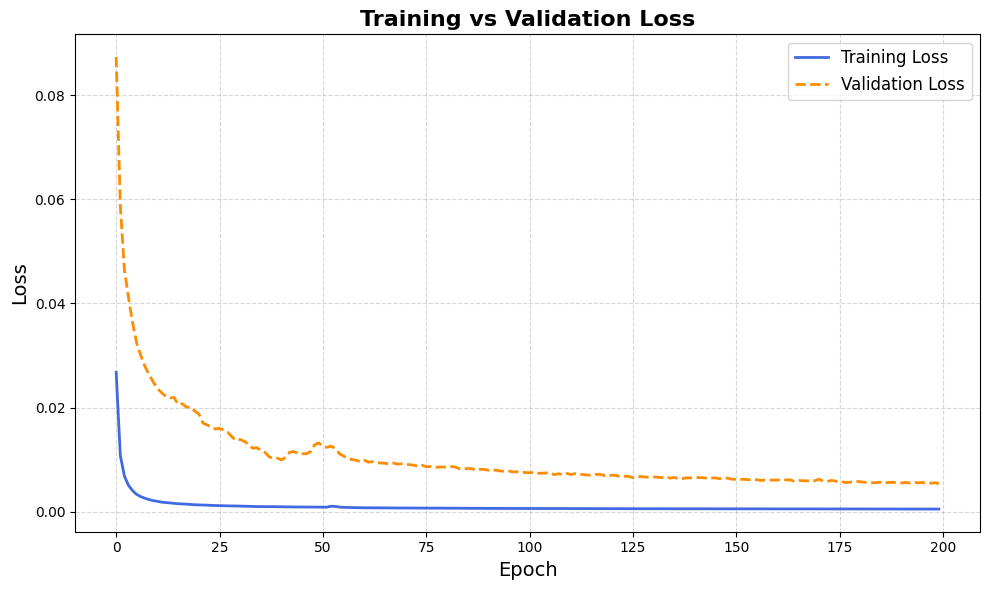

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Plot training & validation
plt.plot(history['train'], label='Training Loss', color='royalblue', linewidth=2)
plt.plot(history['val'], label='Validation Loss', color='darkorange', linewidth=2, linestyle='--')

# Add title and labels
plt.title('Training vs Validation Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Grid & legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


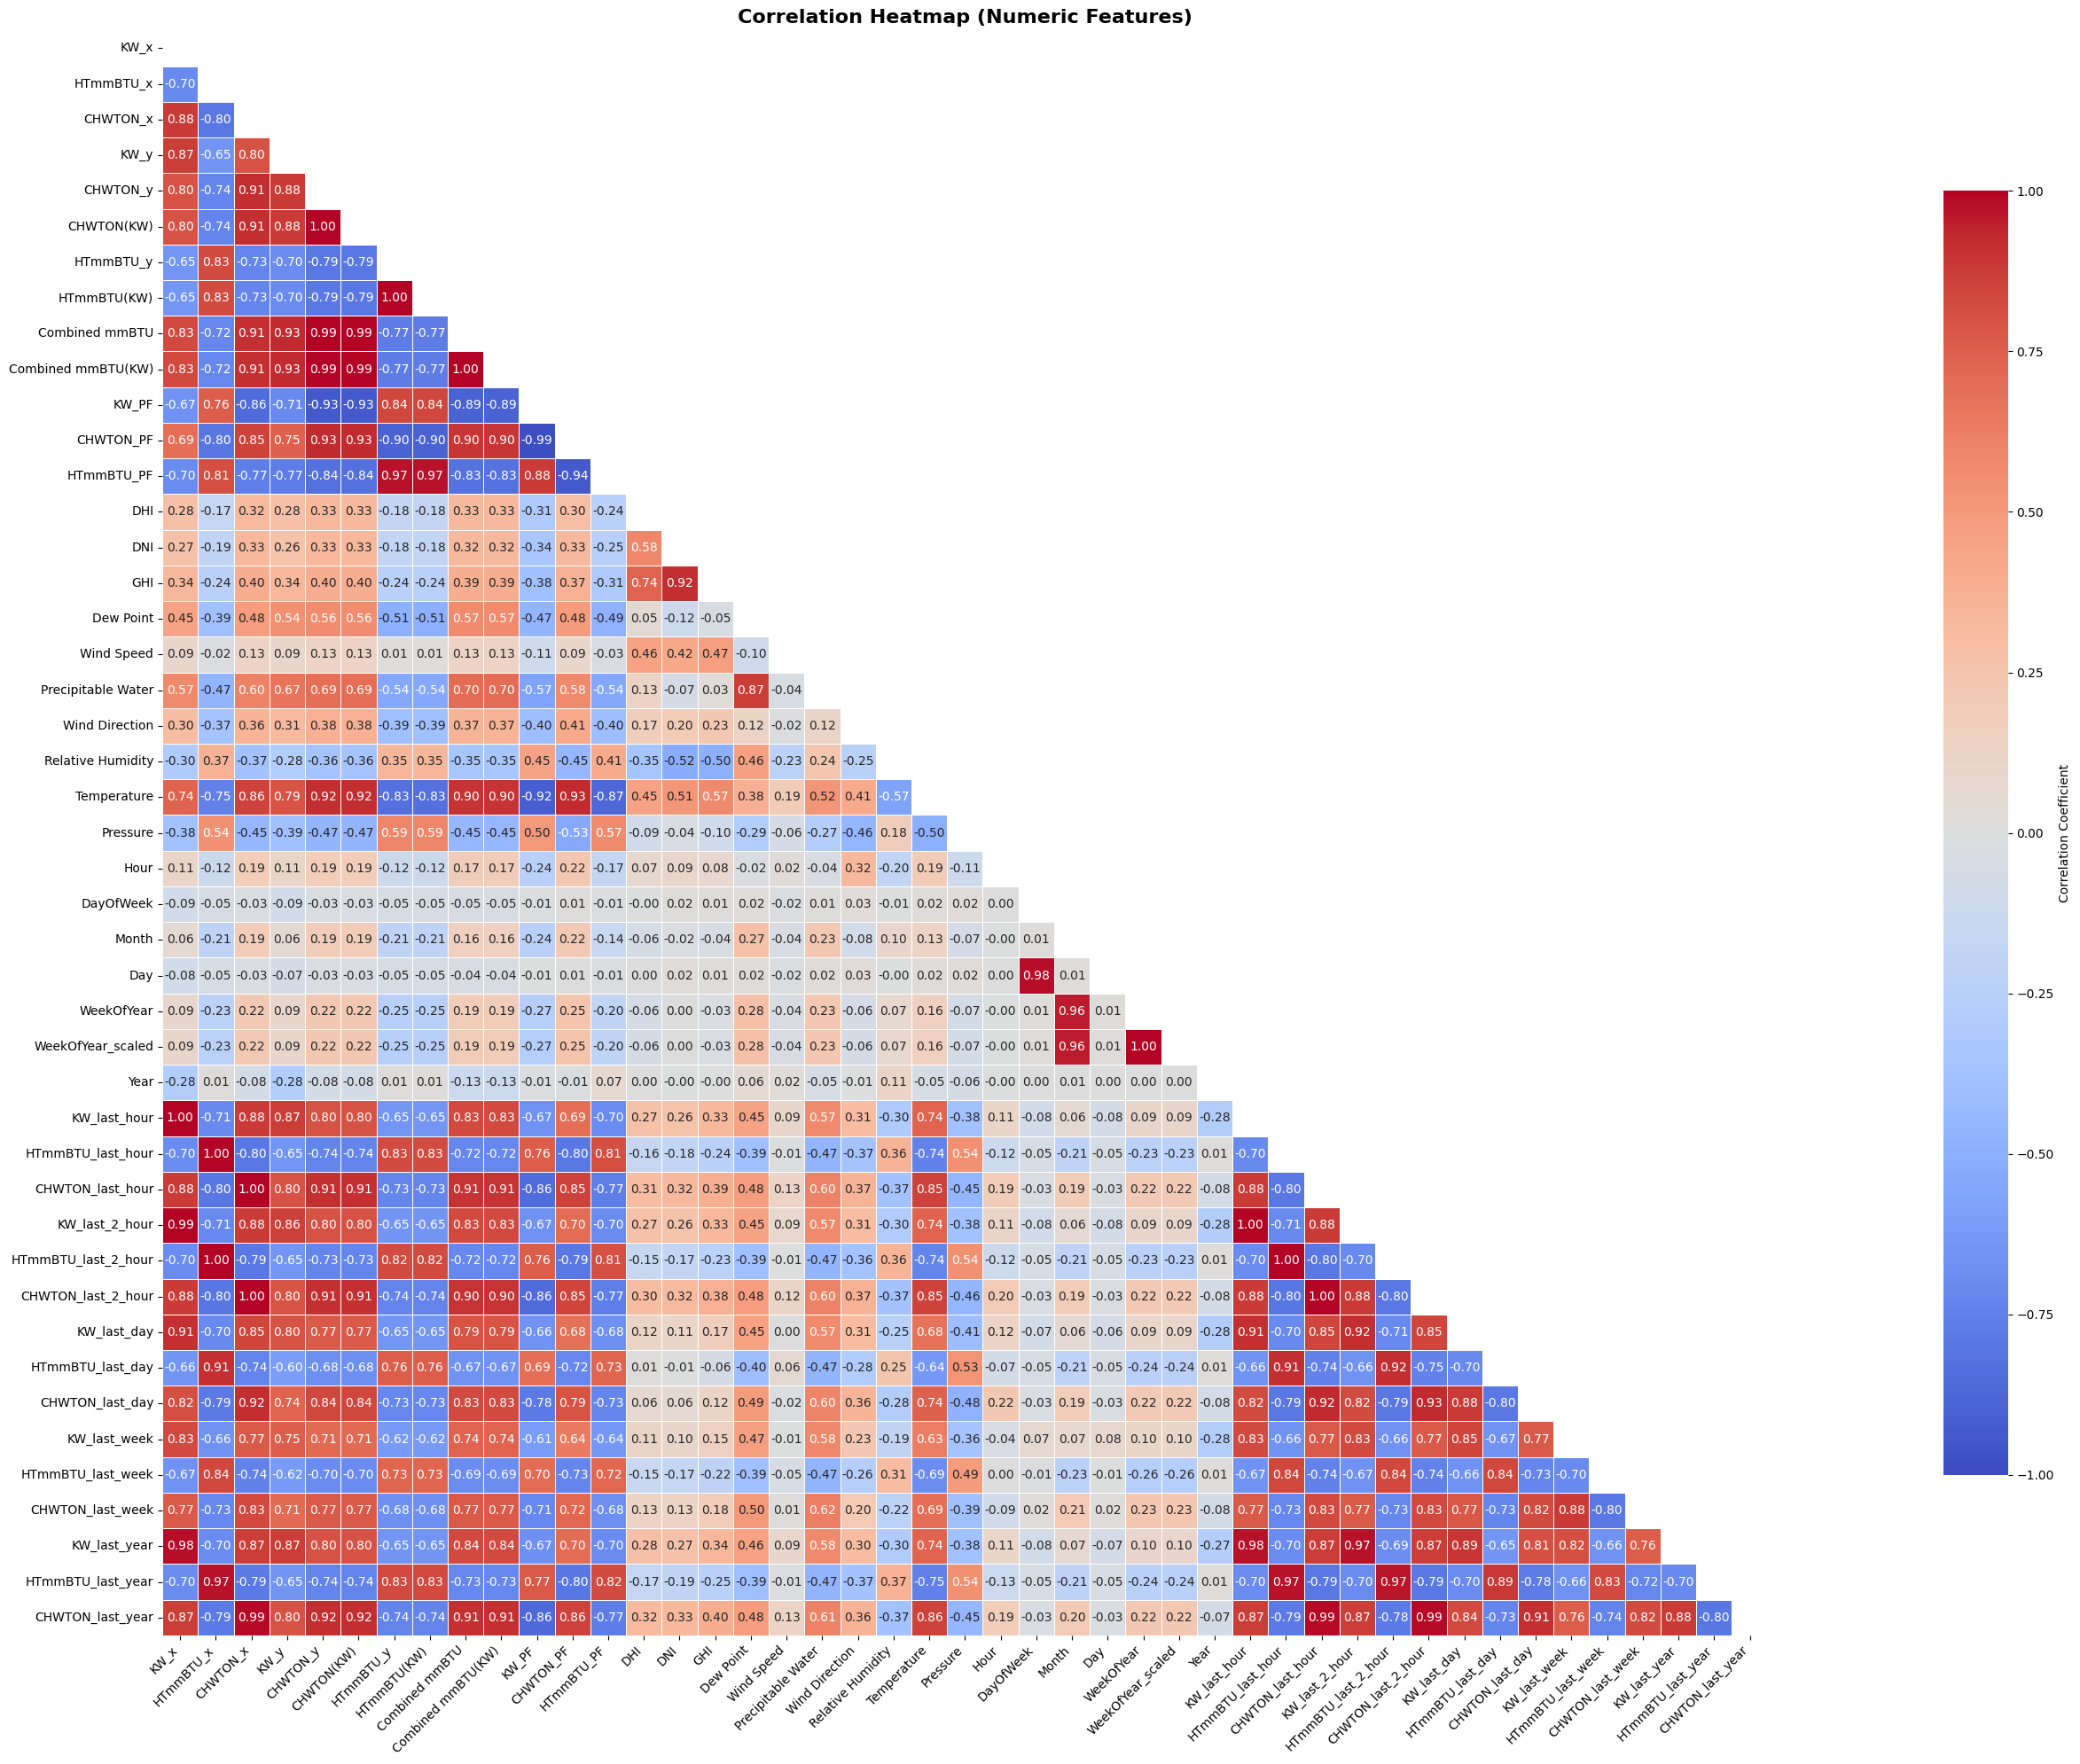

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Keep only numeric columns
numeric_data = data.select_dtypes(include=['number'])

# Compute the correlation matrix
corr = numeric_data.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(40,20))

# Draw the heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    vmax=1.0,
    vmin=-1.0,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .8, 'label': 'Correlation Coefficient'},
    annot=True,
    fmt=".2f"
)

plt.title('Correlation Heatmap (Numeric Features)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

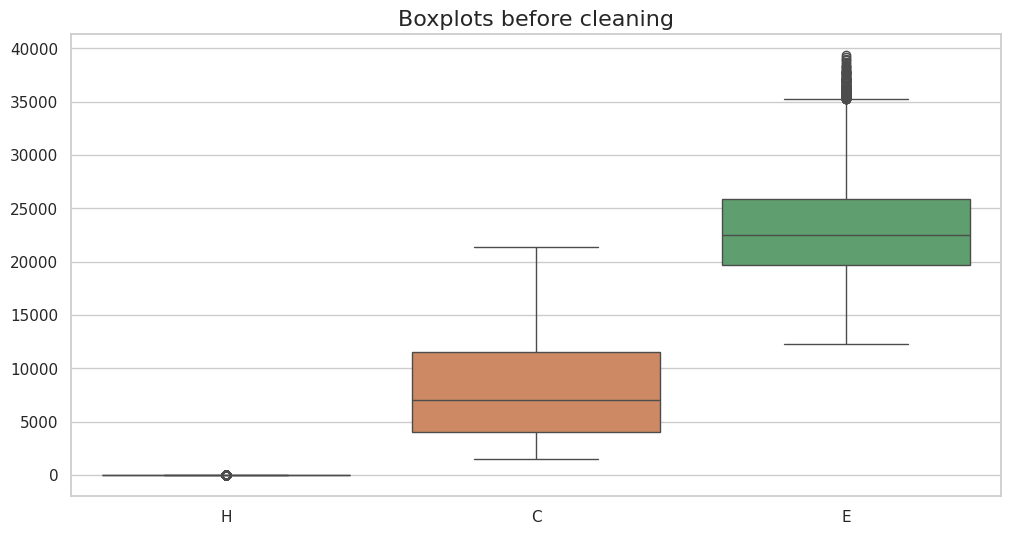

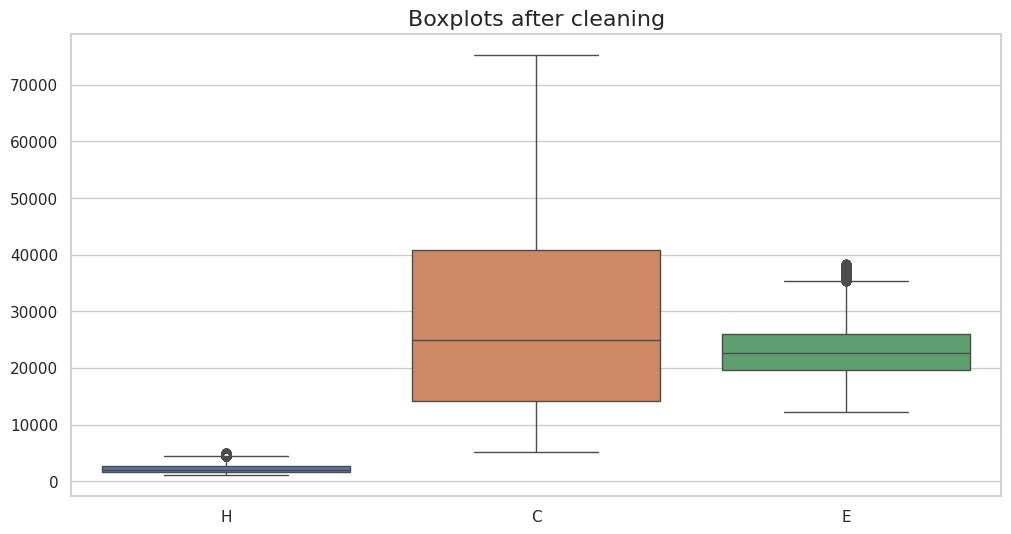

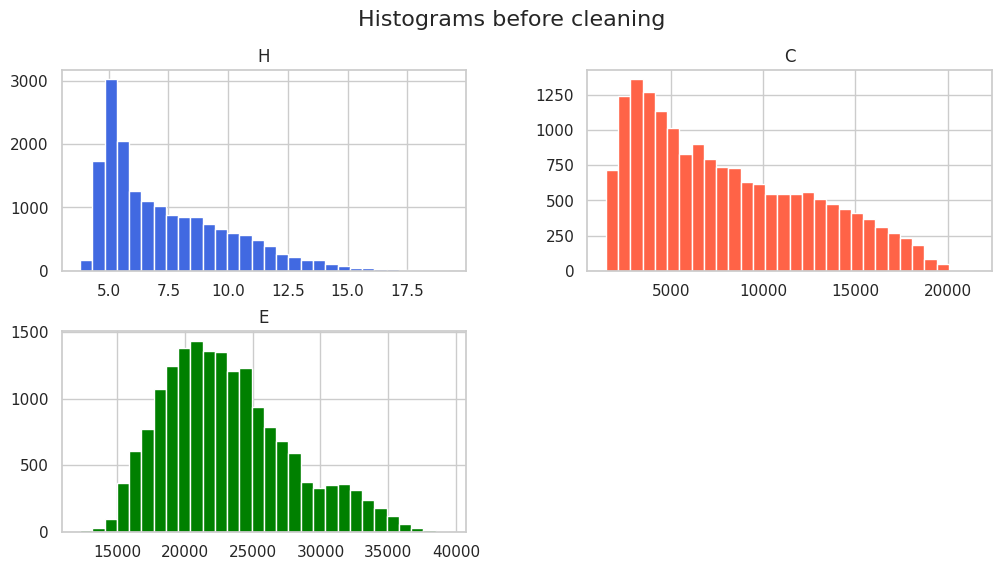

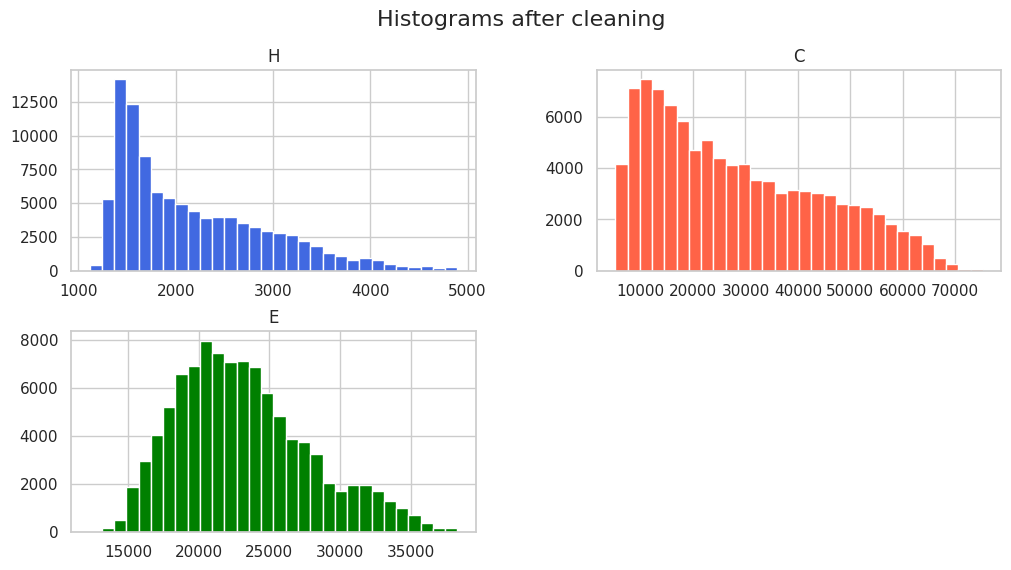

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

data_cleaned =data.copy()


# Rename columns to match what your plots expect
data_cleaned.rename(columns={
    'KW_x': 'E',
    'HTmmBTU_x': 'H',
    'CHWTON_x': 'C'
}, inplace=True)

# Do the same rename on raw_data too, so both have same columns
raw_data.rename(columns={
    'KW': 'E',
    'HTmmBTU': 'H',
    'CHWTON': 'C'
}, inplace=True)

sns.set(style='whitegrid')

# Boxplots before cleaning
plt.figure(figsize=(12,6))
sns.boxplot(data=raw_data[['H','C','E']])
plt.title('Boxplots before cleaning', fontsize=16)
plt.show()

# Boxplots after cleaning
plt.figure(figsize=(12,6))
sns.boxplot(data=data_cleaned[['H','C','E']])
plt.title('Boxplots after cleaning', fontsize=16)
plt.show()

# Histograms before cleaning
axes = raw_data[['H','C','E']].hist(bins=30, figsize=(12,6), sharex=False, sharey=False)
for ax, color in zip(axes.flatten(), ['royalblue','tomato','green']):
    ax.set_facecolor('white')
    for patch in ax.patches:
        patch.set_facecolor(color)
plt.suptitle('Histograms before cleaning', fontsize=16)
plt.show()

# Histograms after cleaning
axes = data_cleaned[['H','C','E']].hist(bins=30, figsize=(12,6), sharex=False, sharey=False)
for ax, color in zip(axes.flatten(), ['royalblue','tomato','green']):
    ax.set_facecolor('white')
    for patch in ax.patches:
        patch.set_facecolor(color)
plt.suptitle('Histograms after cleaning', fontsize=16)
plt.show()



In [78]:
# Load raw data again (simulate "before cleaning")
raw_data = pd.read_csv('data_set_adjusted.csv')  # replace with your real file

# Rename columns if needed
raw_data.rename(columns={
    'KW_x': 'E',
    'HTmmBTU_x': 'H',
    'CHWTON_x': 'C'
}, inplace=True)


In [73]:
test_losses_heat = []
test_losses_cool = []
test_losses_elec = []
heat_pred_total = []
cool_pred_total = []
elec_pred_heat = []
test_losses = []

for ValidXHeat, ValidYHeat, ValidXCool, ValidYCool, ValidXElec, ValidYElec in tes_dataloader:
    seq_inp_heat = ValidXHeat.to(device)
    seq_true_heat = ValidYHeat.to(device)
    seq_inp_cool = ValidXCool.to(device)
    seq_true_cool = ValidYCool.to(device)
    seq_inp_elec = ValidXElec.to(device)
    seq_true_elec = ValidYElec.to(device)

    seq_pred_heat, seq_pred_cool, seq_pred_elec = model(seq_inp_heat, seq_inp_cool, seq_inp_elec)

    # Keep as tensors!
    heat_pred_total.append(seq_pred_heat.detach().cpu())
    cool_pred_total.append(seq_pred_cool.detach().cpu())
    elec_pred_heat.append(seq_pred_elec.detach().cpu())

    loss_heat = criterion(seq_pred_heat, seq_true_heat)
    loss_cool = criterion(seq_pred_cool, seq_true_cool)
    loss_elec = criterion(seq_pred_elec, seq_true_elec)

    test_losses_heat.append(loss_heat.item())
    test_losses_cool.append(loss_cool.item())
    test_losses_elec.append(loss_elec.item())
    test_losses.append((loss_heat + loss_cool + loss_elec).item())



In [84]:
heat_pred_total = torch.cat(heat_pred_total,dim=0).detach().numpy()
cool_pred_total = torch.cat(cool_pred_total,dim=0).detach().numpy()
elec_pred_heat = torch.cat(elec_pred_heat,dim=0).detach().numpy()


In [90]:
print(list(elec_test_scaler.feature_names_in_))


['KW', 'HTmmBTU', 'CHWTON', 'KW_y', 'CHWTON_y', 'CHWTON(KW)', 'HTmmBTU_y', 'HTmmBTU(KW)', 'Combined mmBTU', 'Combined mmBTU(KW)', 'KW_PF', 'CHWTON_PF', 'HTmmBTU_PF', 'DHI', 'DNI', 'GHI', 'Dew Point', 'Wind Speed', 'Precipitable Water', 'Wind Direction', 'Relative Humidity', 'Temperature', 'Pressure', 'Hour', 'DayOfWeek', 'Month', 'Day', 'WeekOfYear', 'WeekOfYear_scaled', 'Year', 'KW_last_hour', 'HTmmBTU_last_hour', 'CHWTON_last_hour', 'KW_last_2_hour', 'HTmmBTU_last_2_hour', 'CHWTON_last_2_hour', 'KW_last_day', 'HTmmBTU_last_day', 'CHWTON_last_day', 'KW_last_week', 'HTmmBTU_last_week', 'CHWTON_last_week', 'KW_last_year', 'HTmmBTU_last_year', 'CHWTON_last_year']


In [91]:
data.rename(columns={
    'KW': 'E',
    'HTmmBTU': 'H',
    'CHWTON': 'C'
}, inplace=True)

# Find target index in scaler
target_idx = list(elec_test_scaler.feature_names_in_).index('KW')


# Create dummy arrays filled with zeros
dummy_pred = np.zeros((elec_pred_heat.shape[0], len(elec_test_scaler.feature_names_in_)))
dummy_lab = np.zeros((elec_tes_lab.shape[0], len(elec_test_scaler.feature_names_in_)))

# Fill only the target column
dummy_pred[:, target_idx] = elec_pred_heat.flatten()
dummy_lab[:, target_idx] = elec_tes_lab.flatten()

# Inverse transform
real_pred_elec_full = elec_test_scaler.inverse_transform(dummy_pred)
real_labs_elec_full = elec_test_scaler.inverse_transform(dummy_lab)

# Extract only the target column (now back in original scale)
real_pred_elec = real_pred_elec_full[:, target_idx]
real_labs_elec = real_labs_elec_full[:, target_idx]


In [95]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from math import sqrt

mape_elec = mean_absolute_percentage_error(real_labs_elec, real_pred_elec) * 100
rmse_elec = sqrt(mean_squared_error(real_labs_elec, real_pred_elec))

print(f"The electric load MAPE is {mape_elec:.2f} %")
print(f"The electric load RMSE is {rmse_elec:.2f} kW")



The electric load MAPE is 2.17 %
The electric load RMSE is 545.35 kW


In [97]:
# Find target index in scaler
target_idx_cool = list(cool_test_scaler.feature_names_in_).index('CHWTON')

# Create dummy arrays filled with zeros
dummy_pred_cool = np.zeros((cool_pred_total.shape[0], len(cool_test_scaler.feature_names_in_)))
dummy_lab_cool = np.zeros((cool_tes_lab.shape[0], len(cool_test_scaler.feature_names_in_)))

# Fill only the target column
dummy_pred_cool[:, target_idx_cool] = cool_pred_total.flatten()
dummy_lab_cool[:, target_idx_cool] = cool_tes_lab.flatten()

# Inverse transform
real_pred_cool_full = cool_test_scaler.inverse_transform(dummy_pred_cool)
real_labs_cool_full = cool_test_scaler.inverse_transform(dummy_lab_cool)

# Extract only the target column (now back in original scale)
real_pred_cool = real_pred_cool_full[:, target_idx_cool]
real_labs_cool = real_labs_cool_full[:, target_idx_cool]


In [114]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from math import sqrt

mape_cool = mean_absolute_percentage_error(real_labs_cool, real_pred_cool) * 100
rmse_cool = sqrt(mean_squared_error(real_labs_cool, real_pred_cool))

print(f"The cooling load MAPE is {mape_cool:.2f} %")
print(f"The cooling load RMSE is {rmse_cool:.2f} kW")



The cooling load MAPE is 4.59 %
The cooling load RMSE is 764.03 kW


In [99]:
# Find target index in scaler
target_idx_heat = list(heat_test_scaler.feature_names_in_).index('HTmmBTU')

# Create dummy arrays filled with zeros
dummy_pred_heat = np.zeros((heat_pred_total.shape[0], len(heat_test_scaler.feature_names_in_)))
dummy_lab_heat = np.zeros((heat_tes_lab.shape[0], len(heat_test_scaler.feature_names_in_)))

# Fill only the target column
dummy_pred_heat[:, target_idx_heat] = heat_pred_total.flatten()
dummy_lab_heat[:, target_idx_heat] = heat_tes_lab.flatten()

# Inverse transform
real_pred_heat_full = heat_test_scaler.inverse_transform(dummy_pred_heat)
real_labs_heat_full = heat_test_scaler.inverse_transform(dummy_lab_heat)

# Extract only the target column (now back in original scale)
real_pred_heat = real_pred_heat_full[:, target_idx_heat]
real_labs_heat = real_labs_heat_full[:, target_idx_heat]


In [115]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from math import sqrt

mape_heat = mean_absolute_percentage_error(real_labs_heat, real_pred_heat) * 100
rmse_heat = sqrt(mean_squared_error(real_labs_heat, real_pred_heat))

print(f"The heating load MAPE is {mape_heat:.2f} %")
print(f"The heating load RMSE is {rmse_heat:.2f} kW")


The heating load MAPE is 3.98 %
The heating load RMSE is 105.85 kW


In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

sns.set_style('whitegrid')  # professional clean background


 Heating load MAPE: 3.98 %
 Heating load RMSE: 105.85 kW


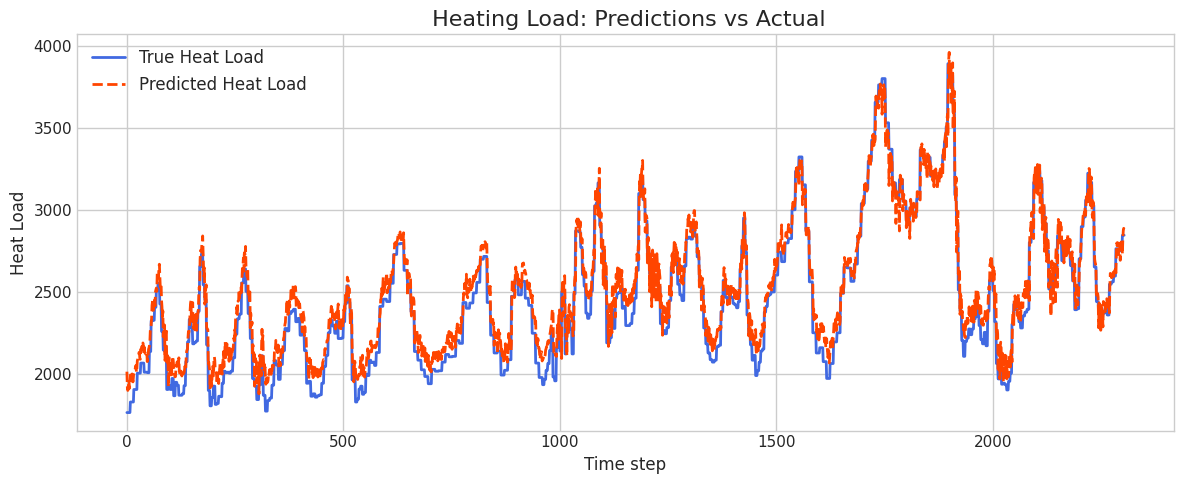

In [108]:


print(f" Heating load MAPE: {mape_heat:.2f} %")
print(f" Heating load RMSE: {rmse_heat:.2f} kW")

# Plot
plt.figure(figsize=(12,5))
plt.plot(real_labs_heat, label='True Heat Load', color='royalblue', linewidth=2)
plt.plot(real_pred_heat, label='Predicted Heat Load', color='orangered', linestyle='--', linewidth=2)
plt.title(' Heating Load: Predictions vs Actual', fontsize=16)
plt.xlabel('Time step')
plt.ylabel('Heat Load')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


 Cooling load MAPE: 4.59 %
 Cooling load RMSE: 764.03 kW


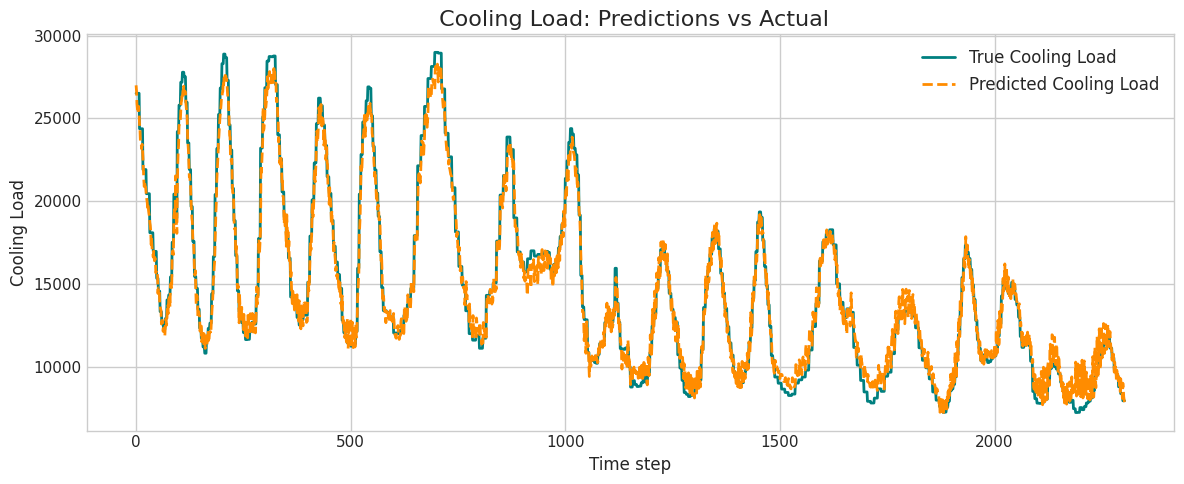

In [109]:

print(f" Cooling load MAPE: {mape_cool:.2f} %")
print(f" Cooling load RMSE: {rmse_cool:.2f} kW")

# Plot
plt.figure(figsize=(12,5))
plt.plot(real_labs_cool, label='True Cooling Load', color='teal', linewidth=2)
plt.plot(real_pred_cool, label='Predicted Cooling Load', color='darkorange', linestyle='--', linewidth=2)
plt.title(' Cooling Load: Predictions vs Actual', fontsize=16)
plt.xlabel('Time step')
plt.ylabel('Cooling Load')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


 Electric load MAPE: 2.17 %
 Electric load RMSE: 545.35 kW


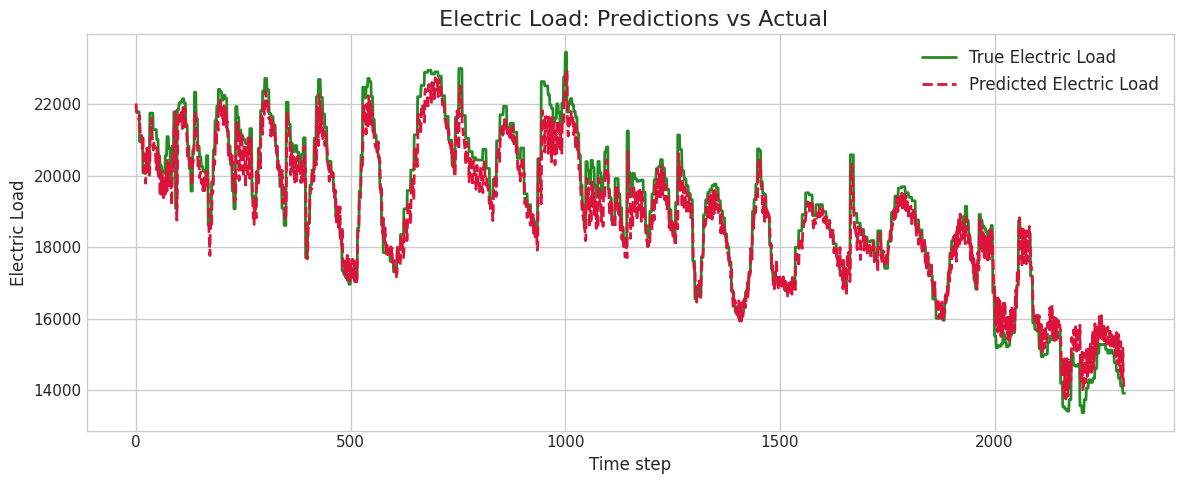

In [117]:


print(f" Electric load MAPE: {mape_elec:.2f} %")
print(f" Electric load RMSE: {rmse_elec:.2f} kW")

# Plot
plt.figure(figsize=(12,5))
plt.plot(real_labs_elec, label='True Electric Load', color='forestgreen', linewidth=2)
plt.plot(real_pred_elec, label='Predicted Electric Load', color='crimson', linestyle='--', linewidth=2)
plt.title(' Electric Load: Predictions vs Actual', fontsize=16)
plt.xlabel('Time step')
plt.ylabel('Electric Load')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


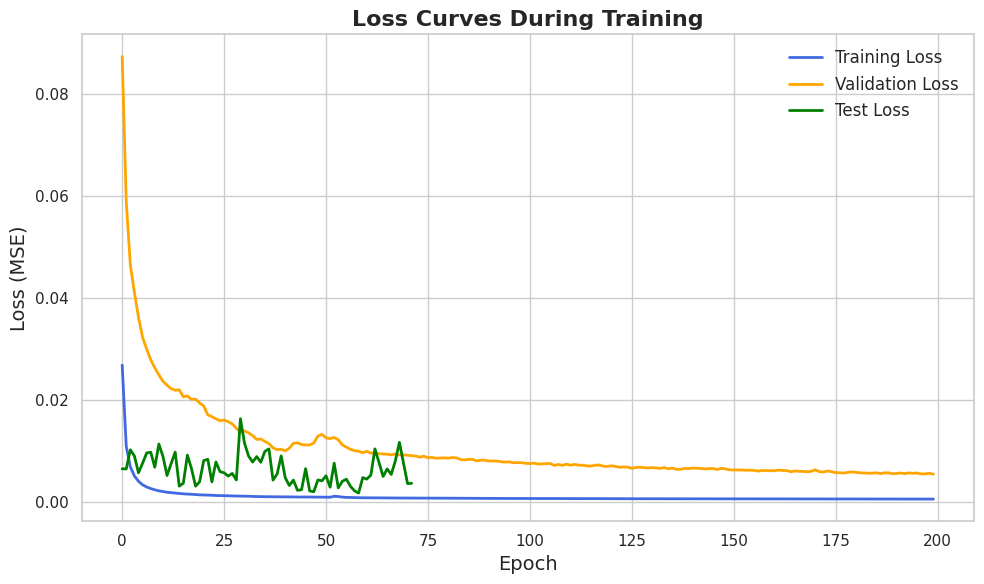

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: replace history['train'] etc. by your real lists
train_losses = history['train']
val_losses = history['val']
test_losses = test_losses  # your collected list from test loop

sns.set(style="whitegrid")
plt.figure(figsize=(10,6))

plt.plot(train_losses, label='Training Loss', color='royalblue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.plot(test_losses, label='Test Loss', color='green', linewidth=2)

plt.title('Loss Curves During Training', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
